# DATA 620 - Final Project

Jeremy OBrien, Mael Illien, Vanita Thompson

## Topic Networks

### Introduction

A powerful analytical application of NLP is topic modeling, which identifies the themes present in a corpus comprised of multiple documents based on the words in those documents. Because it can be used to uncover the thematic structure in documents, topic modeling has an array of applications in information retrieval and document mining.

Topics are 'probability distributions over a fixed vocabulary'. An overview of topic modeling and its current applications in bioinformatics, and it's common to use probabilistic generative models derived from LDA (Latent Dirichlet Allocation) to model in an unsupervised fashion the latent semantic structure of documents. Topic models can be tuned and optimized in a variety of ways, including improving how topics are segregated from each other and calibrating for a useful number of topics.

### Research Question
We will combine techniques from topic modeling and network analysis to address this question.

Given a text corpus comprised of multiple documents, what are the topics of those documents and how are the documents thematically related to one another?

### Approach
- Leverage the Reuters news corpus of nearly 11,000 articles (labeled with at least one category each; unfortunately, authorship is not labeled)
- Using the NLTK, Spacy, and Gensim packages, implement and tune an unsupervised LDA-based topic model (i.e. without reference to the provided article topic labels)
- Analyze model perplexity and coherence, overall topic prevalence, and topic distribution across articles
- Generate a bipartite, weighted (likely on coherence) graph of articles and topics, and analyze its topology to identify relationships between topics

## Setup

In [1]:
import re
import random
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
from nltk.corpus import stopwords
from nltk.corpus import reuters

import spacy  # need to install

import gensim  # need to install
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
# warnings.filterwarnings('ignore', category=DeprecationWarning)

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

## Data Import & Processing

### Data import and preliminary EDA

In [2]:
# NLTK Reuters corpus test
from nltk.corpus import reuters
reuters.fileids()
reuters.words('test/14841')[-10:]

['the', 'shipment', 'was', 'for', 'April', '8', 'to', '20', 'delivery', '.']

Here are 25 sampled categoies from the Reuters corpus. These correspond to themes/topics assigned to documents in the corpus and are essentially labels for the articles.

In [3]:
random.choices(reuters.categories(),k=25)

['fuel',
 'instal-debt',
 'lumber',
 'soy-oil',
 'yen',
 'lumber',
 'retail',
 'copra-cake',
 'jet',
 'rapeseed',
 'dmk',
 'jet',
 'reserves',
 'rand',
 'pet-chem',
 'silver',
 'interest',
 'propane',
 'sun-meal',
 'carcass',
 'copra-cake',
 'alum',
 'nzdlr',
 'lumber',
 'reserves']

In [4]:
# Adjust to generate dataframe directly from nltk corpus
# https://stackoverflow.com/questions/46109166/converting-categorizedplaintextcorpusreader-into-dataframe
news = []
for fileid in reuters.fileids():
    tag, filename = fileid.split('/')
    news.append((filename, tag, reuters.categories(fileid), reuters.raw(fileid)))

df = pd.DataFrame(news, columns=['filename', 'tag', 'categories','text'])

In [5]:
df

,filename,tag,categories,text
0,14826,test,[trade],ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...
1,14828,test,[grain],CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...
2,14829,test,"[crude, nat-gas]",JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...
3,14832,test,"[corn, grain, rice, rubber, sugar, tin, trade]",THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n ...
4,14833,test,"[palm-oil, veg-oil]",INDONESIA SEES CPO PRICE RISING SHARPLY\n Ind...
...,...,...,...,...
10783,999,training,"[interest, money-fx]",U.K. MONEY MARKET SHORTAGE FORECAST REVISED DO...
10784,9992,training,[earn],KNIGHT-RIDDER INC &lt;KRN> SETS QUARTERLY\n Q...
10785,9993,training,[earn],TECHNITROL INC &lt;TNL> SETS QUARTERLY\n Qtly...
10786,9994,training,[earn],NATIONWIDE CELLULAR SERVICE INC &lt;NCEL> 4TH ...


In [6]:
# Output with print

# 10,788 separate cases (news articles)
# df.shape
# len(df.filename.unique())

# Each case is tagged as either train or test
# df.tag.unique()

# There are 10,657 articles with distinct text body - so 131 duplicates
# len(df.text.unique())

# Check the text body of duplicates (except for first instance)
# print(df[df.text.duplicated('first')])

# JO: Evaluate cause and consider case for removal
# MI: I checked with some of the indexes and found no overlap. See below

In [7]:
#print(df[df.text.duplicated('first')])

### Data cleaning and deduplication

In [8]:
# Convert to list
data = df['text'].values.tolist()

# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]

pprint(data[330][:1000])

('G-7 ISSUES STATEMENT AFTER MEETING Following is the text of a statement by '
 'the Group of Seven -- the U.S., Japan, West Germany, France, Britain, Italy '
 'and Canada -- issued after a Washington meeting yesterday. 1. The finance '
 'ministers and central bank governors of seven major industrial countries met '
 'today. They continued the process of multilateral surveillance of their '
 'economies pursuant to the arrangements for strengthened economic policy '
 'coordination agreed at the 1986 Tokyo summit of their heads of state or '
 'government. The managing director of the International Monetary Fund also '
 'participated in the meeting. 2. The ministers and governors reaffirmed the '
 'commitment to the cooperative approach agreed at the recent Paris meeting, '
 'and noted the progress achieved in implementing the undertakings embodied in '
 'the Louvre Agreement. They agreed, however, that further actions will be '
 'essential to resist rising protectionist pressures, sustai

In [9]:
pprint(data[333][:1000])

('JAPAN BUSINESS LEADERS SAY G-7 ACCORD IS WORRYING The leaders of two of '
 'Japans top business groups said in separate statements the Group of Seven '
 '(G-7) accord reached in Washington yesterday is of deep concern to Japan '
 'because it shows the major industrial nations regard the yens current level '
 'as appropriate. Eishiro Saito, chairman of the Federation of Economic '
 'Organizations (Keidanren), said the yens present rate is well above adequate '
 'levels. He did not elaborate. Takashi Ishihara, chairman of the Japan '
 'Committee for Economic Development, said the accord will not prevent the yen '
 'from rising further. "We do not understand why the G-7 approved present '
 'rates as the yen has risen excessively since the Paris accord," Ishihara '
 'said. G-7 members Britain, Canada, France, Italy, Japan, the U.S. And West '
 'Germany said in a statement they consider their currencies are now within '
 'ranges broadly consistent with economic fundamentals. Saito called 

### Text preparation and feature engineering

In [10]:
# Tokenize words and clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[0])

['asian', 'exporters', 'fear', 'damage', 'from', 'japan', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'and', 'japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'asias', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen', 'and', 'officials', 'said', 'they', 'told', 'reuter', 'correspondents', 'in', 'asian', 'capitals', 'move', 'against', 'japan', 'might', 'boost', 'protectionist', 'sentiment', 'in', 'the', 'and', 'lead', 'to', 'curbs', 'on', 'american', 'imports', 'of', 'their', 'products', 'but', 'some', 'exporters', 'said', 'that', 'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'long', 'run', 'in', 'the', 'short', 'term', 'tokyos', 'loss', 'might', 'be', 'their', 'gain', 'the', 'has', 'said', 'it', 'will', 'impose', 'mln', 'dlrs', 'of', 'tariffs', 'on', 'imports', 'of', 'japanese', 'electronics', 'goods', 'on', 'april', 'in', 'retaliation', 'for', 'japans', 'alleged', 'failur

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['asian', 'exporters', 'fear', 'damage', 'from', 'japan', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'and', 'japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'asias', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen', 'and', 'officials', 'said', 'they', 'told', 'reuter_correspondents', 'in', 'asian', 'capitals', 'move', 'against', 'japan', 'might', 'boost', 'protectionist_sentiment', 'in', 'the', 'and', 'lead', 'to', 'curbs', 'on', 'american', 'imports', 'of', 'their', 'products', 'but', 'some', 'exporters', 'said', 'that', 'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'long', 'run', 'in', 'the', 'short_term', 'tokyos', 'loss', 'might', 'be', 'their', 'gain', 'the', 'has', 'said', 'it', 'will', 'impose', 'mln', 'dlrs', 'of', 'tariffs', 'on', 'imports', 'of', 'japanese', 'electronics', 'goods', 'on', 'april', 'in', 'retaliation', 'for', 'japans', 'alleged_failure', 'to', 's

### Pre-processing

In [12]:
# Set up stopwords
stop_words = stopwords.words('english')

# JO: Confirm if these / other stopwords should be added
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [15]:
print(data_lemmatized[0])

['asian', 'exporter', 'fear', 'damage', 'mount', 'trade', 'friction', 'raise', 'fear', 'many', 'asia', 'export', 'nation', 'row', 'could', 'inflict', 'far', 'reach', 'economic', 'damage', 'businessman', 'official', 'say', 'tell', 'asian', 'capital', 'move', 'may', 'boost', 'protectionist_sentiment', 'lead', 'curb', 'american', 'import', 'product', 'exporter', 'say', 'conflict', 'would', 'hurt', 'long', 'run', 'tokyos', 'loss', 'may', 'gain', 'say', 'impose', 'dlrs', 'import', 'japanese', 'electronic', 'good', 'retaliation', 'stick', 'pact', 'sell', 'semiconductor', 'world', 'market', 'cost', 'unofficial', 'japanese', 'estimate', 'put', 'impact', 'tariff', 'dlrs', 'spokesman', 'major', 'electronic', 'firm', 'say', 'would', 'virtually', 'halt', 'export', 'product', 'hit', 'new', 'taxis', 'would', 'able', 'business', 'say', 'spokesman', 'lead', 'japanese', 'electronic', 'firm', 'tariff', 'remain', 'place', 'length', 'time', 'month', 'mean', 'complete', 'erosion', 'export', 'good', 'tariff

In [33]:
# Create dictionary and corpus for topic modeling

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 4), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 2), (35, 1), (36, 3), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 4), (48, 1), (49, 1), (50, 2), (51, 2), (52, 1), (53, 4), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 8), (61, 2), (62, 1), (63, 1), (64, 2), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 6), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 5), (86, 1), (87, 2), (88, 4), (89, 3), (90, 1), (91, 1), (92, 1), (93, 2), (94, 1), (95, 1), (96, 1), (97, 3), (98, 1), (99, 4), (100, 1), (101, 1), (102, 3), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1),

Note that bigram such as 'domestically_produced' and 'protectionist_sentiment' are included in the dictionary.

In [36]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('accounting', 1),
  ('action', 1),
  ('advantage', 1),
  ('allege', 1),
  ('allow', 2),
  ('also', 4),
  ('american', 1),
  ('asia', 1),
  ('asian', 2),
  ('ask', 1),
  ('australia', 1),
  ('australian', 1),
  ('avow', 1),
  ('await', 1),
  ('aware', 1),
  ('barrier', 1),
  ('beef', 1),
  ('big', 1),
  ('block', 1),
  ('boost', 2),
  ('budget', 1),
  ('business', 1),
  ('businessman', 3),
  ('call', 1),
  ('capital', 1),
  ('centre', 1),
  ('chief', 1),
  ('coal', 1),
  ('commercial', 1),
  ('complete', 1),
  ('concern', 2),
  ('conflict', 1),
  ('continue', 1),
  ('cost', 2),
  ('could', 1),
  ('country', 3),
  ('curb', 1),
  ('cut', 1),
  ('damage', 2),
  ('day', 1),
  ('defuse', 1),
  ('deputy', 1),
  ('deterioration', 1),
  ('diplomatic', 1),
  ('disadvantage', 1),
  ('dispute', 2),
  ('dlrs', 4),
  ('domestically_produced', 1),
  ('due', 1),
  ('economic', 2),
  ('economy', 2),
  ('effort', 1),
  ('electronic', 4),
  ('emergency', 1),
  ('end', 1),
  ('erosion', 

## Topic Modeling & Distribution using Gensim

### Preliminary Topic Model

JO: May eliminate in favor of iterative approach to select optimal number of topics below.

In [18]:
# Build topic model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,  # TDF corpus
                                           id2word=id2word,  # dictionary
                                           num_topics=20,  # provisionally set to 20, to be optimized
                                           random_state=100,  # [CONFIRM]
                                           update_every=1,  # how often paramater should be updated
                                           chunksize=100,
                                           passes=10,  # total number of training passes
                                           alpha='auto',  # learn assymetric alpha from training data
                                           per_word_topics=True)

In [19]:
# View topics in LDA model
pprint(lda_model.print_topics())

[(0,
  '0.101*"year" + 0.073*"say" + 0.052*"rise" + 0.032*"expect" + 0.029*"end" + '
  '0.028*"dlrs" + 0.027*"report" + 0.027*"fall" + 0.025*"increase" + '
  '0.025*"first"'),
 (1,
  '0.387*"oil" + 0.073*"reserve" + 0.072*"crude" + 0.068*"barrel" + '
  '0.054*"revise" + 0.051*"morning" + 0.035*"day" + 0.021*"estimate" + '
  '0.018*"assistance" + 0.018*"today"'),
 (2,
  '0.287*"stock" + 0.178*"share" + 0.128*"common" + 0.081*"dividend" + '
  '0.020*"march" + 0.020*"grower" + 0.017*"corporate" + 0.015*"together" + '
  '0.015*"increase" + 0.014*"trust"'),
 (3,
  '0.133*"say" + 0.066*"company" + 0.048*"share" + 0.029*"offer" + 0.022*"buy" '
  '+ 0.022*"dlrs" + 0.019*"unit" + 0.016*"sell" + 0.015*"group" + '
  '0.014*"shareholder"'),
 (4,
  '0.150*"dollar" + 0.090*"currency" + 0.086*"exchange" + 0.086*"mark" + '
  '0.074*"dealer" + 0.074*"yen" + 0.054*"bank" + 0.030*"central" + '
  '0.021*"fall" + 0.021*"intervene"'),
 (5,
  '0.172*"price" + 0.038*"raise" + 0.024*"consumer" + 0.021*"stake" 

### Analyzing Perplexity and Coherence

Perplexity is measure of how well probability distribution / model predicts score
https://en.wikipedia.org/wiki/Perplexity

https://cfss.uchicago.edu/notes/topic-modeling/, provides examples on optimizing perplexity

Coherence is the degree of semantic similarity bnetween high scoring keywords in the topic
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

http://qpleple.com/topic-coherence-to-evaluate-topic-models/, provide intrinsic and extrinsic measures

In [20]:
# Compute model perplexity and coherence score

# Compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_lemmatized, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score', coherence_lda )


Perplexity:  -10.914410328420848

Coherence Score 0.4120619539894778


In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.277225 -0.041883       1        1  23.107609
3     -0.250926  0.086720       2        1  15.620128
0     -0.257851  0.070825       3        1  13.980495
8     -0.164473 -0.000590       4        1   7.483549
11    -0.145979 -0.030925       5        1   6.237281
18    -0.073029  0.241771       6        1   5.395875
5     -0.079533 -0.007394       7        1   5.123475
16    -0.081419 -0.037267       8        1   4.409648
10    -0.037089 -0.269759       9        1   3.188545
4      0.015009 -0.215494      10        1   2.247590
14     0.058822 -0.024720      11        1   2.013872
2      0.103629  0.185302      12        1   1.780530
9      0.131788  0.049461      13        1   1.672951
1      0.086534 -0.047623      14        1   1.647228
13     0.131898  0.066851      15        1   1.523171
12     0.135235  0.108335      16        1   1.522061
17     0.106788 -0.152029      17        1   1.220207
15     0.198716  0.008874      18        1   0.652029
7      0.197318  0.001146      19        1   0.600006
19     0.201787  0.008399      20        1   0.573760, topic_info=            Term          Freq         Total Category  logprob  loglift
155        share   6206.000000   6206.000000  Default  30.0000  30.0000
148          say  33902.000000  33902.000000  Default  29.0000  29.0000
147         sale   3768.000000   3768.000000  Default  28.0000  28.0000
1451          ct   4867.000000   4867.000000  Default  27.0000  27.0000
246          oil   3388.000000   3388.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1885    delegate      0.050067      1.126173  Topic20 -11.0176   2.0475
2660   committee      0.050064      1.126054  Topic20 -11.0176   2.0475
1664    facility      0.050065      1.126131  Topic20 -11.0176   2.0475
1781  management      0.050065      1.126126  Topic20 -11.0176   2.0475
1890     present      0.050065      1.126156  Topic20 -11.0176   2.0475

[852 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1069      4  0.635093     abroad
1069      9  0.358085     abroad
466      18  0.944840     absorb
1070      4  0.209814    account
1070      7  0.316701    account
...     ...       ...        ...
193       8  0.060471  yesterday
193      10  0.072565  yesterday
1648      4  0.991433        yet
1067      4  0.677521      yield
1067      9  0.320449      yield

[1032 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 1, 9, 12, 19, 6, 17, 11, 5, 15, 3, 10, 2, 14, 13, 18, 16, 8, 20])

### Optimizing Number of Topics Parameter

In [22]:
# Consider splitting the model function and the optimization

# Find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 # corpus=corpus, 
                                                 # num_topics=num_topics, 
                                                 # id2word=id2word)
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,  # TDF corpus
                                           id2word=id2word,  # dictionary
                                           num_topics=num_topics,  # to be optimized
                                           random_state=100,  # [CONFIRM]
                                           # update_every=1,  # how often paramater should be updated
                                           # chunksize=100,
                                           # passes=10,  # total number of training passes
                                           # alpha='auto',  # learn assymetric alpha from training data
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Iterate to find optimal model
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

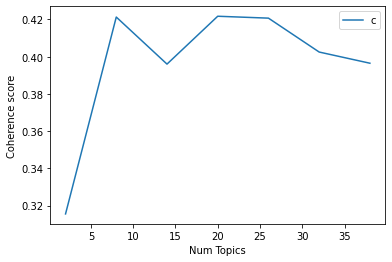

Num topics= 2  has coherence value of 0.3156
Num topics= 8  has coherence value of 0.4213
Num topics= 14  has coherence value of 0.396
Num topics= 20  has coherence value of 0.4217
Num topics= 26  has coherence value of 0.4207
Num topics= 32  has coherence value of 0.4025
Num topics= 38  has coherence value of 0.3965


In [23]:
# Graph iterations
limit=40; start=2; step=6
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print('Num topics=', m, ' has coherence value of', round(cv, 4))

In [24]:
# Set n to optimal model
n = 4  # fifth model has highest coherence value
# We coud reurn in rang 8 to 20 in 1 point increments to smooth and ensure global optimum
optimal_model= model_list[n]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(13,
  '0.057*"say" + 0.022*"offer" + 0.017*"licence" + 0.015*"bonus" + '
  '0.015*"wheat" + 0.012*"export" + 0.011*"tonne" + 0.011*"today" + '
  '0.011*"take" + 0.011*"market"'),
 (2,
  '0.039*"say" + 0.034*"soybean" + 0.031*"acre" + 0.027*"program" + '
  '0.017*"regular" + 0.017*"acreage" + 0.017*"set" + 0.014*"crop" + '
  '0.014*"initial" + 0.013*"aluminium"'),
 (12,
  '0.076*"franc" + 0.024*"french" + 0.022*"say" + 0.013*"cable" + '
  '0.013*"official" + 0.012*"new" + 0.011*"employer" + 0.010*"issue" + '
  '0.010*"redundancy" + 0.009*"sector"'),
 (1,
  '0.064*"oil" + 0.061*"price" + 0.048*"corn" + 0.046*"say" + 0.041*"raise" + '
  '0.028*"crude" + 0.017*"today" + 0.017*"qtly" + 0.015*"tender" + '
  '0.015*"barrel"'),
 (0,
  '0.059*"say" + 0.023*"rate" + 0.015*"growth" + 0.012*"economy" + '
  '0.011*"would" + 0.011*"economic" + 0.010*"dollar" + 0.010*"year" + '
  '0.009*"first" + 0.008*"exchange"'),
 (25,
  '0.060*"price" + 0.040*"say" + 0.029*"year" + 0.024*"production" + '
  '0.0

### Topic Prevalence

In [50]:
# JO: troubleshoot TypeError:  https://cs50.stackexchange.com/questions/30671/typeerror-not-supported-between-instances-of-int-and-tuple


# MI: the error comes the sorting function which cant do a comparison because of the intracte structure of the rows.
# I printed out the content below to look at the structure

# Find dominant topic by sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Loop through articles to get each article's main topic
    for i, article in enumerate(ldamodel[corpus]):
        for article in enumerate(article):  # JO: removed the sort operation here - think we'll need to figure out another way to resort the article value, but leaving for now
            if article[0] == 0:
                
                print(article)
                
                wp = optimal_model.show_topic(article[1][0][0])
                topic_keywords = ', '.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(article[1][0][0]), 
                                                                  round(article[1][0][1],4), 
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    return(sent_topics_df)


In [51]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

# Show
df_dominant_topic.head(10)

(0, [(6, 0.7153767), (8, 0.23550525), (9, 0.0362918)])
(0, [(3, 0.116973326), (8, 0.1855672), (13, 0.3994028), (16, 0.1889228), (25, 0.0903253)])
(0, [(2, 0.015237524), (5, 0.19877137), (8, 0.15528367), (23, 0.4475646), (25, 0.17254658)])
(0, [(0, 0.17898506), (6, 0.10852097), (13, 0.07065674), (23, 0.5200598), (25, 0.11018083)])
(0, [(4, 0.033714868), (8, 0.3999157), (14, 0.03799237), (25, 0.5176642)])
(0, [(6, 0.21605653), (11, 0.27209124), (16, 0.47816303), (25, 0.024562204)])
(0, [(6, 0.038364917), (8, 0.26884007), (11, 0.6423027), (21, 0.04204465)])
(0, [(2, 0.09439865), (13, 0.63603646), (19, 0.223002)])
(0, [(8, 0.37546247), (14, 0.4430108), (22, 0.15883152)])
(0, [(0, 0.03928043), (3, 0.16871934), (5, 0.10635684), (6, 0.21488269), (8, 0.037693977), (11, 0.1335908), (16, 0.010164482), (17, 0.12779085), (22, 0.15891898)])
(0, [(6, 0.52136296), (7, 0.15145004), (8, 0.10583139), (16, 0.10409461), (24, 0.09371078)])
(0, [(3, 0.07252716), (4, 0.5850021), (8, 0.20956248), (17, 0.10700

(0, [(3, 0.48375016), (19, 0.46510383)])
(0, [(3, 0.34036186), (5, 0.30026492), (9, 0.21618205), (10, 0.073782966), (11, 0.04639885)])
(0, [(0, 0.012820548), (1, 0.012820548), (2, 0.012820548), (3, 0.012820548), (4, 0.012820548), (5, 0.012820548), (6, 0.012820548), (7, 0.012820548), (8, 0.012820548), (9, 0.6794863), (10, 0.012820548), (11, 0.012820548), (12, 0.012820548), (13, 0.012820548), (14, 0.012820548), (15, 0.012820548), (16, 0.012820548), (17, 0.012820548), (18, 0.012820548), (19, 0.012820548), (20, 0.012820548), (21, 0.012820548), (22, 0.012820548), (23, 0.012820548), (24, 0.012820548), (25, 0.012820548)])
(0, [(2, 0.23699665), (20, 0.6790845)])
(0, [(20, 0.75961494)])
(0, [(8, 0.40698183), (14, 0.5146328), (21, 0.068327285)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 0.03846154), (8, 0.03846154), (9, 0.03846154), (10, 0.03846154), (11, 0.03846154), (12, 0.03846154), (13, 0.03846154), (14, 0.

(0, [(3, 0.64259875), (7, 0.03709749), (9, 0.07297062), (10, 0.03073745), (17, 0.16295382), (19, 0.036906507)])
(0, [(24, 0.52367556), (25, 0.4147796)])
(0, [(18, 0.95993567)])
(0, [(6, 0.13421564), (13, 0.4212558), (14, 0.22972348), (17, 0.07861934), (24, 0.116132095)])
(0, [(9, 0.70936424), (18, 0.2290904)])
(0, [(7, 0.33916247), (19, 0.5582619)])
(0, [(7, 0.21295801), (20, 0.67165583)])
(0, [(0, 0.019231062), (1, 0.019231062), (2, 0.019231062), (3, 0.019231062), (4, 0.019231062), (5, 0.019231062), (6, 0.019231062), (7, 0.019231062), (8, 0.019231062), (9, 0.019231062), (10, 0.019231062), (11, 0.019231062), (12, 0.019231062), (13, 0.019231062), (14, 0.019231062), (15, 0.019231062), (16, 0.019231062), (17, 0.019231062), (18, 0.5192234), (19, 0.019231062), (20, 0.019231062), (21, 0.019231062), (22, 0.019231062), (23, 0.019231062), (24, 0.019231062), (25, 0.019231062)])
(0, [(5, 0.13518882), (18, 0.83502376)])
(0, [(3, 0.6745094), (5, 0.08697403), (7, 0.07449706), (23, 0.12874159)])
(0, 

(0, [(2, 0.02479785), (3, 0.27620277), (5, 0.5001945), (16, 0.06988524), (17, 0.054606047), (25, 0.06750132)])
(0, [(8, 0.121579416), (23, 0.36958197), (25, 0.49182415)])
(0, [(0, 0.4573522), (6, 0.24114354), (8, 0.08795786), (9, 0.029526792), (11, 0.17169303), (16, 0.010200041)])
(0, [(18, 0.93131846)])
(0, [(17, 0.19550323), (18, 0.672625)])
(0, [(2, 0.6741705), (8, 0.19272333), (21, 0.074873574), (25, 0.046475727)])
(0, [(17, 0.1575362), (18, 0.20085116), (20, 0.5678834)])
(0, [(7, 0.10114898), (8, 0.2215788), (11, 0.10734243), (22, 0.5611292)])
(0, [(0, 0.5301889), (4, 0.12911592), (6, 0.11932545), (11, 0.070043154), (15, 0.03200586), (17, 0.09568778), (23, 0.02100531)])
(0, [(17, 0.06731442), (23, 0.89848036)])
(0, [(5, 0.5916766), (9, 0.16162658), (19, 0.21509661)])
(0, [(6, 0.60971934), (8, 0.24429795), (13, 0.13351615)])
(0, [(2, 0.12801252), (8, 0.709396), (9, 0.104174905), (15, 0.03920078)])
(0, [(0, 0.044233523), (3, 0.22410312), (6, 0.32383752), (8, 0.10466767), (11, 0.0814

(0, [(3, 0.7405308), (19, 0.18409726)])
(0, [(0, 0.42921627), (2, 0.03165928), (4, 0.15175438), (8, 0.28494632), (15, 0.078637354)])
(0, [(1, 0.24694112), (6, 0.20779693), (9, 0.073724225), (25, 0.41948873)])
(0, [(3, 0.37822372), (7, 0.34062976), (10, 0.011031107), (11, 0.020118218), (19, 0.13135624), (23, 0.107939295)])
(0, [(18, 0.80769217)])
(0, [(0, 0.13924596), (6, 0.03961477), (11, 0.025682423), (13, 0.15479346), (14, 0.33280867), (16, 0.11115214), (25, 0.19101049)])
(0, [(2, 0.8988855), (20, 0.06418223)])
(0, [(1, 0.10455729), (3, 0.6558962), (7, 0.09858687), (20, 0.12859975)])
(0, [(0, 0.012820558), (1, 0.012820558), (2, 0.012820558), (3, 0.012820558), (4, 0.012820558), (5, 0.012820558), (6, 0.012820558), (7, 0.012820558), (8, 0.012820558), (9, 0.012820558), (10, 0.012820558), (11, 0.012820558), (12, 0.012820558), (13, 0.012820558), (14, 0.012820558), (15, 0.012820558), (16, 0.012820558), (17, 0.012820558), (18, 0.67948604), (19, 0.012820558), (20, 0.012820558), (21, 0.0128205

(0, [(6, 0.09682738), (16, 0.0685912), (21, 0.21767385), (23, 0.594032)])
(0, [(5, 0.97252434)])
(0, [(0, 0.0793223), (8, 0.18069567), (9, 0.12123817), (10, 0.23676929), (14, 0.010105187), (22, 0.13751547), (23, 0.22185673)])
(0, [(15, 0.40696704), (17, 0.22171938), (18, 0.28284964)])
(0, [(24, 0.94342786)])
(0, [(7, 0.14263536), (17, 0.16608188), (18, 0.38040236), (19, 0.21685801)])
(0, [(18, 0.15832256), (20, 0.73911273)])
(0, [(20, 0.8626356)])
(0, [(5, 0.3573075), (9, 0.3815538), (17, 0.12758715), (18, 0.11431916)])
(0, [(1, 0.49218506), (6, 0.46511084)])
(0, [(4, 0.08404092), (8, 0.037929375), (15, 0.59118706), (23, 0.26744753)])
(0, [(18, 0.828278), (23, 0.06915166)])
(0, [(19, 0.17166886), (20, 0.7129446)])
(0, [(18, 0.94658107)])
(0, [(7, 0.11828062), (19, 0.43483946), (22, 0.33621782)])
(0, [(1, 0.20174299), (20, 0.58944637), (22, 0.12034321)])
(0, [(7, 0.53873634), (18, 0.23507248), (20, 0.15810631)])
(0, [(11, 0.12506996), (19, 0.7825958)])
(0, [(18, 0.7596151)])
(0, [(11, 0

(0, [(2, 0.25958708), (3, 0.1679521), (6, 0.036888335), (10, 0.038237218), (19, 0.44282186), (24, 0.032517962)])
(0, [(0, 0.07780486), (3, 0.22622702), (19, 0.6406586)])
(0, [(3, 0.3737624), (5, 0.35341102), (13, 0.21296063), (17, 0.042226225)])
(0, [(3, 0.16349994), (5, 0.160372), (9, 0.16441742), (18, 0.06550712), (22, 0.32740387), (25, 0.10712522)])
(0, [(3, 0.966838)])
(0, [(12, 0.06489029), (17, 0.17992172), (18, 0.7031471)])
(0, [(16, 0.17444547), (19, 0.65324706), (22, 0.13691878)])
(0, [(17, 0.13697037), (20, 0.09015629), (25, 0.7610577)])
(0, [(2, 0.073574916), (5, 0.036323834), (9, 0.19173148), (10, 0.026580855), (14, 0.46738732), (23, 0.1895857)])
(0, [(23, 0.8626368)])
(0, [(4, 0.862635)])
(0, [(15, 0.7041495), (18, 0.20354082)])
(0, [(0, 0.39525688), (5, 0.10301568), (9, 0.31868848), (22, 0.16539524)])
(0, [(18, 0.893159)])
(0, [(18, 0.8076857)])
(0, [(18, 0.90384597)])
(0, [(10, 0.15511331), (18, 0.78719056)])
(0, [(4, 0.47034317), (15, 0.09757555), (18, 0.051774643), (23

(0, [(2, 0.06141929), (4, 0.05199567), (13, 0.20550762), (18, 0.114946626), (19, 0.5352124)])
(0, [(9, 0.4906075), (18, 0.17219228), (20, 0.045618728), (23, 0.26525742)])
(0, [(3, 0.5725659), (5, 0.25020805), (11, 0.1567442), (24, 0.014635341)])
(0, [(2, 0.014569371), (4, 0.6543662), (12, 0.17511386), (17, 0.14481322)])
(0, [(2, 0.30549788), (7, 0.033162728), (11, 0.62828285), (14, 0.022474296)])
(0, [(4, 0.10784945), (13, 0.5331411), (17, 0.19699061), (23, 0.13706085)])
(0, [(1, 0.24192205), (3, 0.24771373), (24, 0.46121)])
(0, [(4, 0.8240462), (24, 0.13199545)])
(0, [(4, 0.65799814), (5, 0.11356838), (24, 0.20960104)])
(0, [(0, 0.16057876), (3, 0.032006398), (4, 0.04739642), (6, 0.49747378), (8, 0.108895205), (11, 0.030859454), (12, 0.10249845)])
(0, [(21, 0.71485716), (24, 0.16975552)])
(0, [(7, 0.16905566), (14, 0.125079), (21, 0.12682512), (23, 0.2585705), (25, 0.2665966)])
(0, [(8, 0.370014), (23, 0.27639323), (25, 0.34615573)])
(0, [(0, 0.5531021), (5, 0.01526107), (6, 0.0921749

(0, [(18, 0.95192295)])
(0, [(17, 0.06791172), (18, 0.87778664)])
(0, [(18, 0.9434387)])
(0, [(18, 0.80769086)])
(0, [(0, 0.26762268), (5, 0.078011654), (9, 0.13603166), (19, 0.05240265), (22, 0.45879468)])
(0, [(2, 0.016093343), (3, 0.0477553), (6, 0.84384626), (8, 0.051385645), (23, 0.035700846)])
(0, [(0, 0.091332376), (6, 0.081108496), (7, 0.1439369), (8, 0.17335965), (14, 0.45457324), (22, 0.046911746)])
(0, [(18, 0.60730153), (20, 0.3597308)])
(0, [(15, 0.3042345), (21, 0.31242839), (24, 0.3029082)])
(0, [(7, 0.24330539), (18, 0.6989979)])
(0, [(18, 0.94939095)])
(0, [(5, 0.04406773), (6, 0.6470072), (16, 0.29743204)])
(0, [(5, 0.11757265), (9, 0.15512122), (16, 0.0548167), (17, 0.25030228), (18, 0.06883961), (23, 0.34818336)])
(0, [(18, 0.2326858), (22, 0.34012225), (23, 0.41079032)])
(0, [(3, 0.587029), (7, 0.10536687), (11, 0.25043282), (20, 0.04038968)])
(0, [(9, 0.93990237)])
(0, [(18, 0.7596152)])
(0, [(18, 0.91986924)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154

(0, [(3, 0.030823786), (5, 0.520799), (7, 0.1518246), (8, 0.08851428), (18, 0.03177574), (22, 0.14159699), (25, 0.026246164)])
(0, [(3, 0.34358314), (18, 0.5640329)])
(0, [(17, 0.18119664), (18, 0.47758764), (19, 0.23063615)])
(0, [(3, 0.36805138), (7, 0.1759983), (15, 0.34145936), (20, 0.09723262)])
(0, [(4, 0.13663031), (18, 0.5098059), (19, 0.29458493)])
(0, [(18, 0.87018335), (20, 0.07212125)])
(0, [(3, 0.37269035), (7, 0.24427085), (14, 0.34457472)])
(0, [(9, 0.3711218), (22, 0.31138328), (23, 0.30485204)])
(0, [(3, 0.24684772), (9, 0.21584536), (20, 0.09654882), (22, 0.21785097), (23, 0.16811182), (25, 0.039400723)])
(0, [(0, 0.10473486), (5, 0.4411892), (13, 0.2619916), (19, 0.14753708)])
(0, [(0, 0.054659758), (18, 0.13690582), (22, 0.7857446)])
(0, [(6, 0.25085327), (12, 0.065307684), (23, 0.26535258), (25, 0.4048342)])
(0, [(3, 0.62805957), (10, 0.33499277)])
(0, [(10, 0.13393141), (14, 0.10762413), (19, 0.6847151)])
(0, [(0, 0.029281218), (3, 0.47279528), (11, 0.15138476), (

(0, [(5, 0.31073916), (17, 0.090712674), (19, 0.5672248)])
(0, [(8, 0.9932665)])
(0, [(23, 0.963016)])
(0, [(7, 0.074243635), (12, 0.03893107), (16, 0.72358906), (19, 0.14521569)])
(0, [(7, 0.52720326), (15, 0.15774164), (19, 0.25975144)])
(0, [(1, 0.23324676), (20, 0.66418713)])
(0, [(18, 0.8798039)])
(0, [(9, 0.9356402)])
(0, [(3, 0.96599793), (9, 0.022616731)])
(0, [(8, 0.99217534)])
(0, [(17, 0.26609012), (18, 0.58005905)])
(0, [(14, 0.25749388), (19, 0.5415381), (22, 0.112474576)])
(0, [(17, 0.26625094), (18, 0.5798985)])
(0, [(18, 0.8798076)])
(0, [(7, 0.41311648), (13, 0.07744957), (19, 0.22516492), (25, 0.23723926)])
(0, [(17, 0.16627087), (18, 0.5499506), (19, 0.18548419)])
(0, [(7, 0.14836411), (18, 0.50710446), (20, 0.2560599)])
(0, [(7, 0.48958826), (12, 0.10374087), (18, 0.33294585)])
(0, [(7, 0.2727724), (19, 0.4964568)])
(0, [(19, 0.9581912)])
(0, [(3, 0.801752), (16, 0.022881156), (18, 0.031815264), (19, 0.09639879), (20, 0.034121774)])
(0, [(1, 0.12005051), (20, 0.7773

(0, [(7, 0.15955205), (9, 0.32438827), (22, 0.48752144)])
(0, [(1, 0.015848385), (3, 0.3638845), (5, 0.240093), (6, 0.042603582), (8, 0.29544526), (16, 0.036847945)])
(0, [(20, 0.80769205)])
(0, [(20, 0.18950756), (24, 0.5797212)])
(0, [(20, 0.50105846), (24, 0.3670721)])
(0, [(20, 0.6367798), (24, 0.2606551)])
(0, [(20, 0.44848636), (24, 0.3976658)])
(0, [(5, 0.28890124), (20, 0.1879842), (24, 0.39672333)])
(0, [(12, 0.13501325), (23, 0.6166397), (25, 0.20411381)])
(0, [(18, 0.9656154)])
(0, [(8, 0.21102495), (18, 0.6966506)])
(0, [(3, 0.2717268), (7, 0.44874194), (8, 0.123938106), (12, 0.07196185), (15, 0.07444766)])
(0, [(0, 0.792982), (1, 0.015350179), (6, 0.1302322), (8, 0.030505834), (15, 0.02451625)])
(0, [(6, 0.07000007), (8, 0.5272364), (23, 0.3935557)])
(0, [(23, 0.9434306)])
(0, [(3, 0.05453569), (6, 0.9392596)])
(0, [(18, 0.12712544), (20, 0.7959511)])
(0, [(0, 0.012820643), (1, 0.012820643), (2, 0.012820643), (3, 0.012820643), (4, 0.012820643), (5, 0.012820643), (6, 0.0128

(0, [(6, 0.8421502), (23, 0.1397458)])
(0, [(3, 0.877143), (8, 0.024353836), (19, 0.05934893), (24, 0.025489682)])
(0, [(5, 0.6405965), (8, 0.15931623), (14, 0.16134882), (23, 0.028140696)])
(0, [(19, 0.70224184), (23, 0.22081572)])
(0, [(3, 0.16731353), (8, 0.12906793), (11, 0.6534611), (22, 0.041945484)])
(0, [(2, 0.070384175), (4, 0.024345392), (8, 0.025467232), (14, 0.2950638), (16, 0.5595811), (18, 0.014878758)])
(0, [(4, 0.94939196)])
(0, [(5, 0.14798923), (11, 0.52872664), (19, 0.3022483)])
(0, [(0, 0.012820595), (1, 0.012820595), (2, 0.012820595), (3, 0.012820595), (4, 0.012820595), (5, 0.012820595), (6, 0.012820595), (7, 0.012820595), (8, 0.012820595), (9, 0.012820595), (10, 0.012820595), (11, 0.012820595), (12, 0.012820595), (13, 0.012820595), (14, 0.012820595), (15, 0.012820595), (16, 0.012820595), (17, 0.012820595), (18, 0.012820595), (19, 0.6794851), (20, 0.012820595), (21, 0.012820595), (22, 0.012820595), (23, 0.012820595), (24, 0.012820595), (25, 0.012820595)])
(0, [(3, 

(0, [(0, 0.9746612)])
(0, [(5, 0.61738354), (7, 0.32727453)])
(0, [(0, 0.6114971), (3, 0.043437965), (6, 0.24541518), (8, 0.02307882), (11, 0.04376504), (21, 0.012185794)])
(0, [(0, 0.012820527), (1, 0.012820527), (2, 0.012820527), (3, 0.012820527), (4, 0.012820527), (5, 0.012820527), (6, 0.012820527), (7, 0.012820527), (8, 0.012820527), (9, 0.012820527), (10, 0.012820527), (11, 0.012820527), (12, 0.012820527), (13, 0.012820527), (14, 0.012820527), (15, 0.012820527), (16, 0.012820527), (17, 0.012820527), (18, 0.6794868), (19, 0.012820527), (20, 0.012820527), (21, 0.012820527), (22, 0.012820527), (23, 0.012820527), (24, 0.012820527), (25, 0.012820527)])
(0, [(3, 0.43338257), (19, 0.5153309)])
(0, [(18, 0.8626372)])
(0, [(5, 0.24488346), (8, 0.19329666), (9, 0.061983116), (13, 0.1988442), (14, 0.1627888), (16, 0.112122215)])
(0, [(1, 0.11335165), (8, 0.21925063), (13, 0.604194)])
(0, [(0, 0.208668), (9, 0.06444052), (17, 0.6826399)])
(0, [(0, 0.040650442), (16, 0.94037104)])
(0, [(3, 0.5

(0, [(8, 0.42770082), (15, 0.029996905), (16, 0.3586889), (25, 0.17479406)])
(0, [(7, 0.061264846), (9, 0.2280102), (18, 0.14587425), (20, 0.030875813), (22, 0.18255536), (23, 0.33504963)])
(0, [(9, 0.7777416), (17, 0.031989675), (18, 0.17257556)])
(0, [(0, 0.16916178), (2, 0.011646374), (4, 0.08826061), (8, 0.28691494), (11, 0.09069477), (15, 0.17770107), (17, 0.15671644)])
(0, [(18, 0.9434388)])
(0, [(3, 0.2240891), (5, 0.17861669), (7, 0.23991436), (19, 0.3324789)])
(0, [(0, 0.29976773), (6, 0.054902494), (8, 0.21081083), (11, 0.078984916), (15, 0.027089154), (17, 0.072472334), (23, 0.25355303)])
(0, [(18, 0.8076899)])
(0, [(3, 0.24176529), (5, 0.074219055), (6, 0.107419156), (17, 0.08930179), (19, 0.3633062), (25, 0.09831669)])
(0, [(18, 0.89316225)])
(0, [(3, 0.95482486)])
(0, [(8, 0.955547), (9, 0.02665668)])
(0, [(0, 0.53002673), (3, 0.010945025), (6, 0.17881827), (8, 0.056737926), (11, 0.17221718), (17, 0.034696348)])
(0, [(9, 0.09067216), (13, 0.08583659), (19, 0.42278236), (2

(0, [(11, 0.42709887), (13, 0.44843102), (19, 0.09842231)])
(0, [(11, 0.1865842), (13, 0.5927774), (16, 0.1946386)])
(0, [(8, 0.51168585), (11, 0.033508457), (14, 0.19595693), (22, 0.12770201), (23, 0.054704577), (25, 0.07150699)])
(0, [(2, 0.18065402), (3, 0.07604377), (6, 0.25521624), (9, 0.27255082), (19, 0.06564069), (22, 0.12853488)])
(0, [(0, 0.01923079), (1, 0.01923079), (2, 0.01923079), (3, 0.01923079), (4, 0.01923079), (5, 0.01923079), (6, 0.01923079), (7, 0.01923079), (8, 0.01923079), (9, 0.01923079), (10, 0.01923079), (11, 0.01923079), (12, 0.01923079), (13, 0.01923079), (14, 0.01923079), (15, 0.01923079), (16, 0.01923079), (17, 0.01923079), (18, 0.5192302), (19, 0.01923079), (20, 0.01923079), (21, 0.01923079), (22, 0.01923079), (23, 0.01923079), (24, 0.01923079), (25, 0.01923079)])
(0, [(18, 0.7596142)])
(0, [(16, 0.4737859), (23, 0.4800507)])
(0, [(1, 0.4812937), (8, 0.24474883), (14, 0.26032043)])
(0, [(3, 0.62182903), (14, 0.16188245), (20, 0.12183027), (22, 0.063113175)

(0, [(3, 0.24088578), (11, 0.43338847), (19, 0.12944625), (22, 0.09822136), (23, 0.06919888)])
(0, [(3, 0.035358395), (5, 0.37817997), (7, 0.13889077), (8, 0.09746463), (9, 0.053574443), (11, 0.19433758), (22, 0.09637801)])
(0, [(1, 0.50117856), (3, 0.3661432), (16, 0.10583162)])
(0, [(1, 0.81311995), (9, 0.109933645)])
(0, [(1, 0.9358969)])
(0, [(18, 0.5656478), (20, 0.24973536)])
(0, [(0, 0.03333016), (16, 0.9154579), (21, 0.040605195)])
(0, [(1, 0.7653092), (9, 0.17313716)])
(0, [(18, 0.8931607)])
(0, [(1, 0.76401275), (9, 0.14365406)])
(0, [(1, 0.9125866)])
(0, [(1, 0.7640864), (9, 0.14358032)])
(0, [(1, 0.63421416), (18, 0.2734389)])
(0, [(18, 0.91987133)])
(0, [(18, 0.90384597)])
(0, [(7, 0.17044751), (18, 0.7372407)])
(0, [(18, 0.9443748), (20, 0.023794595)])
(0, [(8, 0.07334366), (18, 0.8722979)])
(0, [(4, 0.17448334), (8, 0.09566588), (10, 0.028958203), (15, 0.5629374), (16, 0.11722542)])
(0, [(1, 0.6427329), (10, 0.067163035), (19, 0.101831116), (20, 0.14595772)])
(0, [(3, 0.

(0, [(0, 0.7470593), (6, 0.064961664), (8, 0.0927006), (16, 0.06078747), (23, 0.031036701)])
(0, [(0, 0.65504247), (23, 0.22951165)])
(0, [(0, 0.26545906), (8, 0.21342188), (23, 0.5113897)])
(0, [(3, 0.3438778), (11, 0.07024313), (22, 0.58045703)])
(0, [(0, 0.14491557), (9, 0.5116742), (18, 0.31181356)])
(0, [(0, 0.21378359), (8, 0.10010579), (16, 0.048331168), (23, 0.6047545), (25, 0.025254464)])
(0, [(17, 0.8931618)])
(0, [(4, 0.1716514), (6, 0.6474318), (7, 0.112858914)])
(0, [(3, 0.07437475), (17, 0.8948536)])
(0, [(4, 0.414513), (6, 0.55127263)])
(0, [(0, 0.77919835), (4, 0.09519477), (8, 0.052404985), (23, 0.038382042), (25, 0.03155989)])
(0, [(9, 0.5244685), (18, 0.45301676)])
(0, [(0, 0.14879), (6, 0.7977848), (23, 0.042500805)])
(0, [(1, 0.0643266), (2, 0.04333971), (3, 0.071123526), (4, 0.17629777), (5, 0.18074806), (8, 0.29833287), (9, 0.05216543), (14, 0.10442319)])
(0, [(4, 0.23439915), (8, 0.443569), (15, 0.10228731), (17, 0.06282461), (23, 0.15277646)])
(0, [(2, 0.080965

(0, [(0, 0.071739), (2, 0.8989472)])
(0, [(6, 0.045559842), (8, 0.6266263), (11, 0.2529607), (17, 0.061421815)])
(0, [(18, 0.8805432), (20, 0.06176416)])
(0, [(18, 0.95192236)])
(0, [(3, 0.096914165), (6, 0.83493316), (8, 0.063091084)])
(0, [(0, 0.045953557), (3, 0.14868446), (7, 0.114582114), (11, 0.3326258), (13, 0.29271045), (15, 0.03661345), (22, 0.01869225)])
(0, [(5, 0.38202697), (25, 0.5781903)])
(0, [(3, 0.6522538), (12, 0.045288615), (17, 0.092457876), (22, 0.1786504)])
(0, [(3, 0.43776384), (4, 0.05032366), (7, 0.35585248), (22, 0.13725491)])
(0, [(3, 0.38017058), (5, 0.14537463), (10, 0.08769702), (11, 0.044185925), (19, 0.31467015)])
(0, [(1, 0.16657397), (3, 0.43626267), (5, 0.19144495), (6, 0.16335133)])
(0, [(6, 0.22950527), (11, 0.058057193), (16, 0.27099466), (21, 0.43494076)])
(0, [(8, 0.21308114), (9, 0.14830124), (13, 0.15418485), (16, 0.17449708), (19, 0.28207168)])
(0, [(3, 0.11659207), (8, 0.49376878), (11, 0.109234124), (21, 0.075243145), (23, 0.13198544), (25, 

(0, [(7, 0.18258563), (19, 0.7876368)])
(0, [(1, 0.3617151), (15, 0.33604038), (19, 0.24326344)])
(0, [(10, 0.033077523), (15, 0.8489141), (16, 0.079521954)])
(0, [(3, 0.1734789), (7, 0.41720903), (19, 0.26793343), (20, 0.1164896)])
(0, [(2, 0.119148046), (5, 0.16923426), (6, 0.105916925), (19, 0.38852933), (22, 0.16961074)])
(0, [(13, 0.13158225), (15, 0.07540532), (18, 0.035625823), (19, 0.7221157)])
(0, [(9, 0.25142336), (19, 0.6942722)])
(0, [(18, 0.7596151)])
(0, [(10, 0.7596043)])
(0, [(18, 0.75961393)])
(0, [(16, 0.13094358), (19, 0.65020835), (22, 0.17223407)])
(0, [(18, 0.8485869), (20, 0.080406636)])
(0, [(1, 0.019694075), (3, 0.8653189), (9, 0.09562039), (10, 0.011806682)])
(0, [(7, 0.38448644), (11, 0.060506333), (19, 0.51474917)])
(0, [(0, 0.026771722), (2, 0.19476756), (8, 0.33263713), (14, 0.4376779)])
(0, [(9, 0.59978646), (20, 0.29764822)])
(0, [(2, 0.26020536), (19, 0.5089952)])
(0, [(2, 0.068761855), (5, 0.096866205), (9, 0.09316933), (11, 0.09715591), (19, 0.1200843

(0, [(5, 0.38181233), (15, 0.14751938), (19, 0.4338057)])
(0, [(3, 0.11004063), (6, 0.2718944), (8, 0.5215804), (11, 0.08381933)])
(0, [(3, 0.64989024), (19, 0.25700298), (22, 0.060326036)])
(0, [(1, 0.04189691), (3, 0.19566052), (7, 0.7239764)])
(0, [(6, 0.21373405), (20, 0.43966675), (23, 0.24830452)])
(0, [(2, 0.046535216), (9, 0.012446372), (17, 0.07257369), (20, 0.13599017), (23, 0.65706563), (25, 0.06643828)])
(0, [(0, 0.19345467), (3, 0.34134302), (8, 0.35194448), (15, 0.09633135)])
(0, [(15, 0.8797958)])
(0, [(6, 0.41018125), (11, 0.12430475), (15, 0.42704442)])
(0, [(6, 0.6183996), (8, 0.35273537)])
(0, [(1, 0.04210744), (8, 0.6428743), (16, 0.031379633), (25, 0.27100483)])
(0, [(0, 0.18521138), (3, 0.13920587), (4, 0.17118695), (8, 0.25185025), (11, 0.14123878), (15, 0.10707275)])
(0, [(8, 0.37597218), (11, 0.19017269), (14, 0.15026963), (15, 0.115005426), (22, 0.014148001), (25, 0.15057011)])
(0, [(1, 0.21756776), (8, 0.53563434), (11, 0.09847982), (25, 0.12950988)])
(0, [(1

(0, [(2, 0.016389247), (3, 0.88450956), (8, 0.058822684), (9, 0.016768144), (13, 0.014263724)])
(0, [(7, 0.33651656), (18, 0.49025643), (20, 0.12116826)])
(0, [(3, 0.42960617), (9, 0.40206456), (18, 0.119161114)])
(0, [(18, 0.80768526)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 0.03846154), (8, 0.03846154), (9, 0.03846154), (10, 0.03846154), (11, 0.03846154), (12, 0.03846154), (13, 0.03846154), (14, 0.03846154), (15, 0.03846154), (16, 0.03846154), (17, 0.03846154), (18, 0.03846154), (19, 0.03846154), (20, 0.03846154), (21, 0.03846154), (22, 0.03846154), (23, 0.03846154), (24, 0.03846154), (25, 0.03846154)])
(0, [(18, 0.96898204)])
(0, [(7, 0.42832693), (9, 0.2985398), (20, 0.17484024)])
(0, [(0, 0.15584178), (8, 0.5329604), (11, 0.14390406), (25, 0.1423783)])
(0, [(3, 0.036029242), (6, 0.6852828), (11, 0.10325024), (13, 0.018469434), (14, 0.1274884), (16, 0.016537284)])
(0, [(3, 0.23059802), (5, 0.02

(0, [(0, 0.83141476), (6, 0.110880874)])
(0, [(7, 0.31433916), (17, 0.10904882), (18, 0.5213205)])
(0, [(1, 0.024484124), (3, 0.16105124), (7, 0.61136234), (11, 0.116146326), (20, 0.07079795)])
(0, [(18, 0.9434388)])
(0, [(18, 0.8931613)])
(0, [(2, 0.051567793), (3, 0.13374364), (4, 0.0781826), (8, 0.17681397), (16, 0.270308), (20, 0.012522259), (21, 0.15801871), (23, 0.1130611)])
(0, [(5, 0.11899268), (18, 0.84917325)])
(0, [(18, 0.8798069)])
(0, [(2, 0.30369872), (18, 0.46571), (19, 0.1421216)])
(0, [(18, 0.7596151)])
(0, [(0, 0.025024813), (2, 0.021171158), (5, 0.060700525), (6, 0.16627334), (9, 0.020348234), (16, 0.6988606)])
(0, [(18, 0.7596137)])
(0, [(9, 0.5376994), (14, 0.0490931), (17, 0.039102618), (18, 0.25889918), (23, 0.08827819)])
(0, [(7, 0.06860869), (17, 0.046622377), (18, 0.8637018)])
(0, [(9, 0.3592578), (18, 0.56381196)])
(0, [(3, 0.489936), (7, 0.025313351), (8, 0.046566322), (11, 0.26321372), (16, 0.017249135), (19, 0.14701729)])
(0, [(9, 0.16141526), (14, 0.10994

(0, [(8, 0.26422545), (15, 0.1738499), (16, 0.15840565), (21, 0.21505214), (22, 0.17188716)])
(0, [(5, 0.0836955), (6, 0.8653565), (8, 0.034820966)])
(0, [(1, 0.06402311), (9, 0.47333115), (18, 0.08441505), (20, 0.3547213)])
(0, [(0, 0.019230794), (1, 0.019230794), (2, 0.019230794), (3, 0.019230794), (4, 0.019230794), (5, 0.019230794), (6, 0.019230794), (7, 0.019230794), (8, 0.019230794), (9, 0.019230794), (10, 0.019230794), (11, 0.019230794), (12, 0.019230794), (13, 0.019230794), (14, 0.019230794), (15, 0.019230794), (16, 0.019230794), (17, 0.019230794), (18, 0.5192301), (19, 0.019230794), (20, 0.019230794), (21, 0.019230794), (22, 0.019230794), (23, 0.019230794), (24, 0.019230794), (25, 0.019230794)])
(0, [(0, 0.44367686), (6, 0.44294214), (11, 0.09810784)])
(0, [(6, 0.6036201), (8, 0.24505953), (9, 0.013207661), (13, 0.028356088), (16, 0.10488381)])
(0, [(12, 0.04490066), (18, 0.9362597)])
(0, [(1, 0.27466404), (14, 0.6414179)])
(0, [(18, 0.9542118)])
(0, [(9, 0.5307047), (18, 0.238

(0, [(3, 0.5165405), (8, 0.12603803), (11, 0.34495622)])
(0, [(0, 0.01923079), (1, 0.01923079), (2, 0.01923079), (3, 0.01923079), (4, 0.01923079), (5, 0.01923079), (6, 0.01923079), (7, 0.01923079), (8, 0.01923079), (9, 0.01923079), (10, 0.01923079), (11, 0.01923079), (12, 0.01923079), (13, 0.01923079), (14, 0.01923079), (15, 0.01923079), (16, 0.01923079), (17, 0.01923079), (18, 0.5192302), (19, 0.01923079), (20, 0.01923079), (21, 0.01923079), (22, 0.01923079), (23, 0.01923079), (24, 0.01923079), (25, 0.01923079)])
(0, [(7, 0.18508032), (17, 0.12240242), (18, 0.6040453)])
(0, [(0, 0.09699613), (6, 0.6957314), (8, 0.047729753), (12, 0.03556592), (16, 0.11274652)])
(0, [(6, 0.5780754), (8, 0.2795316), (16, 0.10502695), (25, 0.028355068)])
(0, [(9, 0.72499263), (18, 0.17243856)])
(0, [(9, 0.15899116), (11, 0.34307972), (17, 0.06531318), (20, 0.15933491), (22, 0.2520227)])
(0, [(3, 0.84327316), (9, 0.052733164), (21, 0.063769214)])
(0, [(0, 0.012820683), (1, 0.012820683), (2, 0.012820683), 

(0, [(3, 0.8922891), (10, 0.04878286), (24, 0.042543106)])
(0, [(1, 0.04827723), (10, 0.07922808), (15, 0.07274962), (19, 0.5995236), (22, 0.16507366)])
(0, [(17, 0.350632), (18, 0.51749396)])
(0, [(18, 0.83973163)])
(0, [(18, 0.7596151)])
(0, [(3, 0.67271054), (5, 0.119827434), (7, 0.03728389), (8, 0.03297535), (11, 0.043816566), (17, 0.017075196), (19, 0.066418454)])
(0, [(2, 0.11148535), (18, 0.84235543)])
(0, [(0, 0.019230824), (1, 0.019230824), (2, 0.019230824), (3, 0.019230824), (4, 0.019230824), (5, 0.019230824), (6, 0.019230824), (7, 0.019230824), (8, 0.019230824), (9, 0.51922935), (10, 0.019230824), (11, 0.019230824), (12, 0.019230824), (13, 0.019230824), (14, 0.019230824), (15, 0.019230824), (16, 0.019230824), (17, 0.019230824), (18, 0.019230824), (19, 0.019230824), (20, 0.019230824), (21, 0.019230824), (22, 0.019230824), (23, 0.019230824), (24, 0.019230824), (25, 0.019230824)])
(0, [(10, 0.18212806), (19, 0.7717108)])
(0, [(7, 0.4469109), (14, 0.050057635), (19, 0.22655119),

(0, [(18, 0.9465809)])
(0, [(18, 0.91258234)])
(0, [(6, 0.68646085), (8, 0.21959633), (11, 0.07231335)])
(0, [(9, 0.53559244), (18, 0.3804906)])
(0, [(9, 0.80769163)])
(0, [(1, 0.07058607), (18, 0.26207763), (20, 0.6083576)])
(0, [(4, 0.08146427), (9, 0.28226689), (17, 0.0467254), (18, 0.5472301)])
(0, [(18, 0.94658107)])
(0, [(0, 0.01923079), (1, 0.01923079), (2, 0.01923079), (3, 0.01923079), (4, 0.01923079), (5, 0.01923079), (6, 0.01923079), (7, 0.01923079), (8, 0.01923079), (9, 0.01923079), (10, 0.01923079), (11, 0.01923079), (12, 0.01923079), (13, 0.01923079), (14, 0.01923079), (15, 0.01923079), (16, 0.01923079), (17, 0.01923079), (18, 0.5192302), (19, 0.01923079), (20, 0.01923079), (21, 0.01923079), (22, 0.01923079), (23, 0.01923079), (24, 0.01923079), (25, 0.01923079)])
(0, [(3, 0.7833749), (5, 0.1571156), (24, 0.033480726)])
(0, [(8, 0.57917005), (12, 0.32832783)])
(0, [(20, 0.8931611)])
(0, [(18, 0.9434388)])
(0, [(18, 0.32209274), (20, 0.60098386)])
(0, [(9, 0.4621696), (18, 0

(0, [(7, 0.83913), (17, 0.099327)])
(0, [(3, 0.5269649), (14, 0.20146167), (19, 0.22500816)])
(0, [(3, 0.46004578), (11, 0.06165291), (19, 0.44549415)])
(0, [(7, 0.276992), (17, 0.14956553), (18, 0.5214032)])
(0, [(1, 0.020467797), (3, 0.57491523), (7, 0.18740876), (10, 0.13186768), (19, 0.07306663)])
(0, [(1, 0.15133503), (7, 0.30555236), (18, 0.45462734)])
(0, [(18, 0.9358974)])
(0, [(3, 0.8750019), (5, 0.072504684), (17, 0.03191542)])
(0, [(3, 0.29696926), (9, 0.11372707), (22, 0.521252)])
(0, [(3, 0.32302868), (7, 0.6533009)])
(0, [(7, 0.17271863), (9, 0.40943125), (18, 0.3196017), (20, 0.070040636)])
(0, [(0, 0.01923079), (1, 0.01923079), (2, 0.01923079), (3, 0.01923079), (4, 0.01923079), (5, 0.01923079), (6, 0.01923079), (7, 0.01923079), (8, 0.01923079), (9, 0.01923079), (10, 0.01923079), (11, 0.01923079), (12, 0.01923079), (13, 0.01923079), (14, 0.01923079), (15, 0.01923079), (16, 0.01923079), (17, 0.01923079), (18, 0.5192302), (19, 0.01923079), (20, 0.01923079), (21, 0.01923079

(0, [(3, 0.2784907), (6, 0.50140417), (12, 0.20781437)])
(0, [(18, 0.94939244)])
(0, [(1, 0.12403078), (8, 0.29894975), (23, 0.55490094)])
(0, [(3, 0.41338012), (9, 0.087718725), (10, 0.092245795), (19, 0.08060631), (21, 0.19404824), (22, 0.10546575)])
(0, [(6, 0.20002511), (16, 0.7361905), (24, 0.04495034)])
(0, [(6, 0.11500499), (12, 0.046370506), (19, 0.80322766)])
(0, [(18, 0.9399031)])
(0, [(10, 0.063627265), (14, 0.059419744), (17, 0.107263505), (19, 0.7293949)])
(0, [(18, 0.9581937)])
(0, [(7, 0.1555118), (18, 0.8089805)])
(0, [(18, 0.9399038)])
(0, [(18, 0.1557398), (19, 0.13880448), (22, 0.47728878), (24, 0.163069)])
(0, [(0, 0.019230831), (1, 0.019230831), (2, 0.019230831), (3, 0.019230831), (4, 0.019230831), (5, 0.019230831), (6, 0.019230831), (7, 0.019230831), (8, 0.019230831), (9, 0.019230831), (10, 0.019230831), (11, 0.019230831), (12, 0.019230831), (13, 0.019230831), (14, 0.019230831), (15, 0.019230831), (16, 0.019230831), (17, 0.019230831), (18, 0.019230831), (19, 0.019

(0, [(2, 0.07355552), (8, 0.17962575), (9, 0.16563332), (11, 0.029732512), (14, 0.544718)])
(0, [(23, 0.8076919)])
(0, [(17, 0.8626361)])
(0, [(15, 0.73298013), (18, 0.18310246)])
(0, [(19, 0.21978939), (20, 0.725908)])
(0, [(5, 0.17610843), (20, 0.544052), (22, 0.22779089)])
(0, [(9, 0.14007646), (23, 0.82572407)])
(0, [(5, 0.07977377), (18, 0.8659193)])
(0, [(20, 0.8076921)])
(0, [(0, 0.053843293), (6, 0.010979214), (9, 0.039742436), (16, 0.02012865), (22, 0.3732243), (23, 0.4735083), (24, 0.02405446)])
(0, [(5, 0.34803793), (9, 0.04513297), (11, 0.051748294), (14, 0.03559507), (16, 0.012770045), (23, 0.500886)])
(0, [(3, 0.1076298), (4, 0.12737378), (8, 0.34532237), (9, 0.039693803), (11, 0.12116884), (12, 0.032403532), (16, 0.13156798), (18, 0.027162978), (19, 0.058592554)])
(0, [(0, 0.15839675), (3, 0.09280271), (8, 0.69551075), (12, 0.032037206), (21, 0.013698476)])
(0, [(18, 0.87980735)])
(0, [(9, 0.14283513), (18, 0.1040557), (22, 0.60899675), (23, 0.12571268)])
(0, [(0, 0.0384

(0, [(6, 0.97862405)])
(0, [(4, 0.5923797), (8, 0.1736615), (22, 0.21660715)])
(0, [(0, 0.20348614), (6, 0.3938897), (8, 0.28737968), (16, 0.09516351)])
(0, [(4, 0.8792258), (24, 0.072188534)])
(0, [(4, 0.65044075), (8, 0.1739416), (17, 0.06907523), (19, 0.0899458)])
(0, [(1, 0.028677668), (4, 0.71129525), (12, 0.049303763), (15, 0.19912906)])
(0, [(4, 0.6030757), (8, 0.3749313)])
(0, [(2, 0.031231694), (9, 0.075772054), (19, 0.07723614), (23, 0.6578307), (25, 0.14655198)])
(0, [(3, 0.75364923), (7, 0.10191605), (11, 0.134817)])
(0, [(6, 0.5386745), (17, 0.3294463)])
(0, [(4, 0.44357514), (8, 0.29126686), (15, 0.17055133), (23, 0.07733531)])
(0, [(1, 0.04503133), (2, 0.012597618), (6, 0.052197486), (8, 0.36865473), (11, 0.22200555), (14, 0.07668519), (15, 0.023329003), (21, 0.11338495), (24, 0.08274144)])
(0, [(4, 0.83974105)])
(0, [(4, 0.83974284)])
(0, [(5, 0.3558521), (12, 0.095007606), (14, 0.1836226), (17, 0.13779481), (19, 0.13310279), (21, 0.056148466)])
(0, [(6, 0.16248229), (1

(0, [(0, 0.35455003), (13, 0.016011672), (17, 0.12044683), (22, 0.033985376), (23, 0.46723756)])
(0, [(5, 0.18111934), (18, 0.55206907), (19, 0.17816761)])
(0, [(18, 0.7874141), (20, 0.17961787)])
(0, [(19, 0.20408367), (20, 0.71199876)])
(0, [(0, 0.11833961), (2, 0.52067477), (3, 0.028410489), (6, 0.061877128), (8, 0.07018047), (11, 0.055718884), (14, 0.027976286), (20, 0.011696574), (25, 0.10251715)])
(0, [(18, 0.95192295)])
(0, [(0, 0.08051211), (6, 0.5694092), (8, 0.084744036), (12, 0.055675283), (16, 0.19790253)])
(0, [(3, 0.098479934), (7, 0.07003959), (12, 0.053048044), (19, 0.67047393), (23, 0.07070124)])
(0, [(2, 0.34638304), (20, 0.49976933)])
(0, [(1, 0.057481363), (9, 0.5980296), (18, 0.2587104), (23, 0.07143638)])
(0, [(0, 0.032657027), (3, 0.07277382), (5, 0.28332198), (6, 0.20789343), (16, 0.014188768), (17, 0.3378689), (21, 0.040218234)])
(0, [(0, 0.10933607), (4, 0.14758825), (8, 0.07798312), (9, 0.047846314), (11, 0.36719587), (14, 0.116694555), (23, 0.08108185), (25,

(0, [(2, 0.09938897), (6, 0.07046223), (8, 0.100513324), (11, 0.21347167), (16, 0.4623144), (20, 0.029002782)])
(0, [(7, 0.4219449), (12, 0.19362396), (19, 0.332383)])
(0, [(7, 0.119170934), (8, 0.023640677), (12, 0.19761063), (18, 0.09367544), (19, 0.122738115), (20, 0.113730974), (21, 0.06677241), (23, 0.25126964)])
(0, [(0, 0.0817906), (5, 0.12954344), (8, 0.70538837), (14, 0.07397274)])
(0, [(3, 0.026911816), (4, 0.3687681), (5, 0.03164365), (8, 0.2057138), (13, 0.07663317), (17, 0.11565848), (23, 0.16375208)])
(0, [(5, 0.1383375), (14, 0.83736914)])
(0, [(6, 0.30585498), (8, 0.15475783), (11, 0.029112916), (14, 0.06598676), (16, 0.4318549)])
(0, [(3, 0.68934757), (11, 0.09434999), (22, 0.0583399), (25, 0.13230997)])
(0, [(12, 0.034528524), (23, 0.93250203)])
(0, [(2, 0.1083391), (3, 0.01936395), (5, 0.018987248), (8, 0.57255465), (13, 0.08672557), (14, 0.091120936), (16, 0.09043973)])
(0, [(4, 0.14109029), (8, 0.7878845)])
(0, [(0, 0.15701172), (3, 0.09292066), (4, 0.11175616), (6

(0, [(2, 0.15488015), (3, 0.3840251), (6, 0.029838223), (7, 0.10445993), (16, 0.070604794), (19, 0.2359438)])
(0, [(0, 0.012820539), (1, 0.012820539), (2, 0.012820539), (3, 0.012820539), (4, 0.012820539), (5, 0.012820539), (6, 0.012820539), (7, 0.012820539), (8, 0.012820539), (9, 0.012820539), (10, 0.012820539), (11, 0.012820539), (12, 0.012820539), (13, 0.012820539), (14, 0.012820539), (15, 0.012820539), (16, 0.012820539), (17, 0.012820539), (18, 0.6794865), (19, 0.012820539), (20, 0.012820539), (21, 0.012820539), (22, 0.012820539), (23, 0.012820539), (24, 0.012820539), (25, 0.012820539)])
(0, [(0, 0.068555385), (10, 0.45976645), (19, 0.41962993)])
(0, [(1, 0.1286937), (3, 0.5455733), (7, 0.15172154), (20, 0.16078857)])
(0, [(6, 0.4300905), (14, 0.2171024), (20, 0.31594515)])
(0, [(3, 0.90309733), (13, 0.07195126)])
(0, [(9, 0.23997708), (20, 0.5754062)])
(0, [(14, 0.2061562), (15, 0.28261945), (19, 0.20245293), (24, 0.25235835)])
(0, [(3, 0.06437638), (4, 0.4483452), (6, 0.11270929),

(0, [(2, 0.11582388), (20, 0.7918671)])
(0, [(0, 0.13077366), (2, 0.0391788), (12, 0.12792704), (14, 0.66409343), (21, 0.024332559)])
(0, [(3, 0.25556046), (5, 0.329621), (16, 0.2180502), (25, 0.1711121)])
(0, [(3, 0.38128793), (19, 0.5346938)])
(0, [(2, 0.21431692), (18, 0.32930183), (20, 0.27944544)])
(0, [(9, 0.19114809), (23, 0.7758766)])
(0, [(3, 0.07397925), (6, 0.36936504), (11, 0.10781791), (16, 0.4249161), (21, 0.017067071)])
(0, [(8, 0.53808725), (13, 0.052562788), (17, 0.04087755), (22, 0.34357244)])
(0, [(3, 0.33989975), (7, 0.19782345), (10, 0.020852795), (19, 0.42860192)])
(0, [(1, 0.021075405), (3, 0.2968486), (6, 0.1957121), (11, 0.113312796), (13, 0.01277741), (19, 0.0420637), (22, 0.3128237)])
(0, [(4, 0.6118248), (8, 0.2546794), (11, 0.11613902)])
(0, [(6, 0.109002195), (7, 0.06835625), (10, 0.12399467), (14, 0.20812075), (19, 0.12356769), (22, 0.24723902), (23, 0.09361253)])
(0, [(3, 0.5620859), (20, 0.33161584), (21, 0.0794841)])
(0, [(18, 0.97469616)])
(0, [(5, 0.

(0, [(14, 0.77748173), (23, 0.19536005)])
(0, [(5, 0.19895913), (7, 0.24081278), (8, 0.23839231), (11, 0.19491796), (21, 0.08952978), (23, 0.029192023)])
(0, [(5, 0.46622458), (8, 0.2264261), (22, 0.021216882), (23, 0.2669957), (24, 0.010805845)])
(0, [(7, 0.1459463), (21, 0.1770609), (24, 0.43831438), (25, 0.17355266)])
(0, [(0, 0.066378206), (4, 0.44652012), (5, 0.030214647), (8, 0.10435632), (11, 0.045329086), (12, 0.024685975), (16, 0.047626987), (17, 0.23229757)])
(0, [(5, 0.25411338), (7, 0.3250694), (8, 0.14775047), (11, 0.263658)])
(0, [(0, 0.05031728), (3, 0.15899332), (7, 0.5097312), (11, 0.19903511), (25, 0.074227594)])
(0, [(4, 0.6404751), (11, 0.119210556), (15, 0.066025026), (17, 0.15460289)])
(0, [(3, 0.3821841), (5, 0.1443224), (7, 0.2873807), (8, 0.10272973), (13, 0.07095098)])
(0, [(17, 0.19906215), (18, 0.66906625)])
(0, [(5, 0.31177443), (9, 0.247598), (25, 0.41113725)])
(0, [(5, 0.12417242), (6, 0.10224972), (7, 0.23029123), (8, 0.17661193), (11, 0.13090827), (19, 

(0, [(3, 0.48741558), (19, 0.29907435), (22, 0.15818913)])
(0, [(0, 0.017880954), (1, 0.11317242), (2, 0.027966773), (7, 0.048512664), (8, 0.7426662), (13, 0.016744668), (25, 0.024233868)])
(0, [(9, 0.2005098), (18, 0.7610268)])
(0, [(5, 0.23716733), (9, 0.12726222), (12, 0.16674042), (18, 0.3827305), (23, 0.068536095)])
(0, [(6, 0.371343), (14, 0.35748714), (24, 0.23678713)])
(0, [(3, 0.04998245), (18, 0.92572516)])
(0, [(0, 0.78556055), (21, 0.15289627)])
(0, [(5, 0.030965915), (8, 0.047266133), (9, 0.13134599), (18, 0.09935203), (22, 0.5319106), (23, 0.1511292)])
(0, [(6, 0.91258264)])
(0, [(1, 0.456989), (6, 0.4111282)])
(0, [(15, 0.8076913)])
(0, [(18, 0.93130773)])
(0, [(15, 0.8864583), (16, 0.069581404)])
(0, [(0, 0.26279774), (2, 0.025826313), (3, 0.10979911), (8, 0.09546339), (11, 0.035690106), (14, 0.42672715), (24, 0.03377979)])
(0, [(2, 0.07442316), (6, 0.04749287), (9, 0.1761311), (20, 0.6168476), (24, 0.052788317)])
(0, [(18, 0.8931622)])
(0, [(0, 0.03846154), (1, 0.03846

(0, [(18, 0.8931622)])
(0, [(19, 0.2958451), (22, 0.53512245), (23, 0.056342185), (24, 0.07586312)])
(0, [(23, 0.5471292), (25, 0.36895043)])
(0, [(6, 0.8728916), (8, 0.03392399), (10, 0.010456654), (15, 0.05370482), (18, 0.020960473)])
(0, [(0, 0.012820578), (1, 0.012820578), (2, 0.012820578), (3, 0.6794855), (4, 0.012820578), (5, 0.012820578), (6, 0.012820578), (7, 0.012820578), (8, 0.012820578), (9, 0.012820578), (10, 0.012820578), (11, 0.012820578), (12, 0.012820578), (13, 0.012820578), (14, 0.012820578), (15, 0.012820578), (16, 0.012820578), (17, 0.012820578), (18, 0.012820578), (19, 0.012820578), (20, 0.012820578), (21, 0.012820578), (22, 0.012820578), (23, 0.012820578), (24, 0.012820578), (25, 0.012820578)])
(0, [(2, 0.058046345), (4, 0.042560786), (5, 0.050727446), (6, 0.16150796), (7, 0.064523935), (9, 0.13465737), (15, 0.058049463), (16, 0.28294116), (22, 0.035588212), (25, 0.10247223)])
(0, [(1, 0.024985151), (2, 0.052079886), (18, 0.8808082)])
(0, [(3, 0.6669743), (7, 0.142

(0, [(0, 0.169611), (17, 0.0777051), (18, 0.06170954), (23, 0.6698178)])
(0, [(3, 0.1718007), (9, 0.3835297), (16, 0.07708619), (19, 0.34834582)])
(0, [(7, 0.24623269), (11, 0.19509305), (19, 0.51443607)])
(0, [(0, 0.2355935), (8, 0.023781028), (11, 0.033997953), (15, 0.071180984), (17, 0.55955786), (22, 0.029445795), (25, 0.038840394)])
(0, [(3, 0.23094451), (7, 0.5875272), (20, 0.14992848)])
(0, [(18, 0.8798076)])
(0, [(11, 0.26440468), (15, 0.07877812), (19, 0.25023687), (22, 0.071791515), (25, 0.29803863)])
(0, [(0, 0.26129285), (3, 0.059148487), (5, 0.46708342), (11, 0.01990349), (16, 0.022064473), (17, 0.046281084), (22, 0.07277607), (23, 0.039444346)])
(0, [(0, 0.23671862), (4, 0.011112147), (8, 0.38428038), (11, 0.25603765), (15, 0.04281148), (16, 0.039672967), (23, 0.01927187)])
(0, [(18, 0.9542123)])
(0, [(3, 0.3819394), (7, 0.35386193), (17, 0.04180946), (25, 0.19509129)])
(0, [(20, 0.8397432)])
(0, [(18, 0.720963), (22, 0.22774594)])
(0, [(18, 0.9599353)])
(0, [(0, 0.038461

(0, [(17, 0.74967855), (19, 0.1032852), (23, 0.108557805)])
(0, [(1, 0.21906403), (20, 0.5963199)])
(0, [(6, 0.24336499), (10, 0.05754288), (14, 0.05358604), (16, 0.04780108), (19, 0.2875404), (22, 0.2734734)])
(0, [(18, 0.94658095)])
(0, [(3, 0.3014398), (5, 0.08628596), (9, 0.25654367), (14, 0.073462576), (22, 0.19521137), (23, 0.07253756)])
(0, [(11, 0.07417522), (14, 0.6337204), (16, 0.21257403), (24, 0.05599783)])
(0, [(1, 0.10975972), (17, 0.838955)])
(0, [(0, 0.03758338), (5, 0.026668595), (8, 0.263307), (11, 0.28645867), (14, 0.012005973), (22, 0.07029256), (23, 0.029346382), (25, 0.2622854)])
(0, [(3, 0.91809654), (11, 0.05303674)])
(0, [(3, 0.43744054), (5, 0.3795115), (9, 0.08702365), (16, 0.07678488)])
(0, [(0, 0.1906035), (10, 0.11293565), (13, 0.04704554), (18, 0.043011993), (22, 0.09117445), (23, 0.5056121)])
(0, [(18, 0.9125829)])
(0, [(3, 0.275376), (19, 0.6861598)])
(0, [(19, 0.75961465)])
(0, [(7, 0.5217429), (19, 0.09228676), (22, 0.29329666), (23, 0.06345485)])
(0,

(0, [(3, 0.09696642), (6, 0.29471615), (11, 0.41528556), (12, 0.052780382), (21, 0.12229462)])
(0, [(0, 0.3937744), (4, 0.031515926), (8, 0.34577373), (17, 0.21528445)])
(0, [(22, 0.14480866), (24, 0.78416365)])
(0, [(8, 0.025710134), (18, 0.7977581), (19, 0.04110828), (22, 0.08645872), (24, 0.02759954)])
(0, [(18, 0.9630175)])
(0, [(18, 0.94343877)])
(0, [(3, 0.23516276), (6, 0.02097102), (7, 0.12887453), (8, 0.043993484), (20, 0.05843591), (22, 0.382477), (23, 0.12137638)])
(0, [(2, 0.039681405), (4, 0.08262804), (6, 0.043422244), (23, 0.4260549), (25, 0.37934822)])
(0, [(1, 0.05034404), (5, 0.5098036), (14, 0.3876751)])
(0, [(2, 0.090034045), (3, 0.28540465), (5, 0.38583532), (8, 0.046942573), (9, 0.0556087), (10, 0.12395078)])
(0, [(0, 0.19022049), (7, 0.04597603), (8, 0.082218334), (16, 0.02279299), (17, 0.61153185), (23, 0.04151536)])
(0, [(20, 0.8798052)])
(0, [(3, 0.61194944), (5, 0.14428477), (19, 0.12456412), (23, 0.08781811)])
(0, [(3, 0.27885795), (7, 0.2230766), (19, 0.457

(0, [(2, 0.14016747), (17, 0.7888234)])
(0, [(7, 0.489886), (12, 0.081002586), (14, 0.13478212), (20, 0.0847751), (25, 0.18069193)])
(0, [(3, 0.5620218), (11, 0.29001543), (17, 0.101397015)])
(0, [(0, 0.08861913), (9, 0.06421303), (17, 0.79795974)])
(0, [(3, 0.8250643), (9, 0.14602587)])
(0, [(3, 0.4600997), (11, 0.34168988), (13, 0.021770928), (16, 0.028645555), (22, 0.13514577)])
(0, [(17, 0.5899965), (18, 0.34846073)])
(0, [(18, 0.16747952), (22, 0.7615139)])
(0, [(1, 0.5239672), (2, 0.21298635), (8, 0.04044062), (15, 0.10302951), (20, 0.05493704), (25, 0.04482457)])
(0, [(20, 0.9313175)])
(0, [(18, 0.759615)])
(0, [(18, 0.09837916), (20, 0.83044183)])
(0, [(18, 0.9615376)])
(0, [(18, 0.83974206)])
(0, [(3, 0.79099286), (11, 0.17478856)])
(0, [(0, 0.10845248), (22, 0.37282804), (23, 0.3323662), (25, 0.17247912)])
(0, [(1, 0.039270442), (2, 0.040601525), (15, 0.07936793), (20, 0.80941725)])
(0, [(17, 0.56588864), (23, 0.37255803)])
(0, [(9, 0.81401706), (22, 0.10206541)])
(0, [(20, 0

(0, [(14, 0.76832855), (21, 0.13844086), (25, 0.07653731)])
(0, [(2, 0.031971183), (12, 0.25036305), (14, 0.33445463), (16, 0.33169696), (20, 0.033151105)])
(0, [(0, 0.03587097), (4, 0.06014954), (9, 0.05231546), (13, 0.028551247), (14, 0.18111247), (16, 0.10124859), (21, 0.10344619), (23, 0.11306207), (24, 0.15273547), (25, 0.15440457)])
(0, [(10, 0.056387126), (13, 0.0908919), (14, 0.6113993), (23, 0.21961668)])
(0, [(4, 0.1420585), (16, 0.12972806), (17, 0.19970176), (23, 0.5179248)])
(0, [(3, 0.6508203), (16, 0.061236586), (19, 0.11565152), (22, 0.07695902), (23, 0.061502907)])
(0, [(0, 0.14272195), (4, 0.014562594), (9, 0.033533156), (11, 0.03964334), (20, 0.01796081), (23, 0.73042524), (25, 0.011146067)])
(0, [(23, 0.9125815)])
(0, [(0, 0.14407517), (9, 0.018957024), (12, 0.022507194), (13, 0.019156685), (15, 0.19986217), (18, 0.015419801), (23, 0.5706489)])
(0, [(0, 0.16113433), (2, 0.18904084), (14, 0.55894804), (24, 0.07207118)])
(0, [(0, 0.15369277), (4, 0.23967768), (6, 0.16

(0, [(6, 0.7410285), (16, 0.23466074)])
(0, [(1, 0.029390622), (3, 0.06141038), (4, 0.45510784), (22, 0.4374729)])
(0, [(8, 0.034350026), (10, 0.032702126), (16, 0.030220997), (23, 0.84343284), (25, 0.049895328)])
(0, [(4, 0.57322186), (13, 0.38062245)])
(0, [(1, 0.21120565), (6, 0.10710204), (8, 0.07856877), (11, 0.053536862), (15, 0.04086143), (24, 0.10448321), (25, 0.38549384)])
(0, [(17, 0.55926186), (23, 0.4202208)])
(0, [(3, 0.52726763), (7, 0.16939393), (19, 0.25129858)])
(0, [(17, 0.12374381), (23, 0.76086855)])
(0, [(2, 0.018087452), (4, 0.20607394), (13, 0.054019753), (14, 0.029058091), (23, 0.29566818), (24, 0.38709086)])
(0, [(4, 0.05760212), (5, 0.013262062), (6, 0.20053004), (8, 0.68878466), (13, 0.033194605)])
(0, [(6, 0.572022), (8, 0.060738567), (11, 0.09411483), (12, 0.024355095), (13, 0.08327136), (25, 0.15009597)])
(0, [(13, 0.15830268), (24, 0.75777286)])
(0, [(0, 0.09075512), (4, 0.14294988), (23, 0.72782457)])
(0, [(3, 0.9542049)])
(0, [(3, 0.5981951), (10, 0.065

(0, [(18, 0.87980515)])
(0, [(0, 0.03717124), (3, 0.38569894), (5, 0.03395189), (8, 0.017139085), (9, 0.13226841), (17, 0.015457018), (22, 0.3704764)])
(0, [(17, 0.9493888)])
(0, [(0, 0.16740642), (3, 0.30138564), (5, 0.14010681), (8, 0.14154436), (11, 0.061984982), (13, 0.015291889), (16, 0.1191858), (19, 0.045538828)])
(0, [(4, 0.11268986), (15, 0.8630174)])
(0, [(2, 0.08757931), (8, 0.050446335), (11, 0.10953035), (16, 0.24318357), (25, 0.4839999)])
(0, [(3, 0.16154069), (19, 0.15867999), (20, 0.41587955), (22, 0.21935216)])
(0, [(18, 0.7596151)])
(0, [(19, 0.93131775)])
(0, [(1, 0.9134432), (18, 0.05358726)])
(0, [(3, 0.29261768), (9, 0.28954312), (14, 0.12925619), (19, 0.24403752)])
(0, [(8, 0.7623773), (12, 0.06352293), (13, 0.06702398), (22, 0.091667496)])
(0, [(3, 0.16164052), (6, 0.29058075), (7, 0.09142074), (9, 0.101764075), (13, 0.042502247), (16, 0.16934538), (22, 0.08092094), (23, 0.053055115)])
(0, [(3, 0.14972106), (6, 0.5567289), (10, 0.020272348), (16, 0.12948188), (2

(0, [(7, 0.06818401), (9, 0.09417171), (18, 0.45551655), (20, 0.33233416)])
(0, [(3, 0.12659973), (9, 0.2610389), (14, 0.039728012), (22, 0.2469382), (23, 0.306903)])
(0, [(1, 0.258513), (9, 0.12820561), (14, 0.28000027), (16, 0.3030547)])
(0, [(17, 0.22723126), (22, 0.22828437), (23, 0.4461923)])
(0, [(0, 0.26249152), (2, 0.0263931), (6, 0.54208463), (12, 0.04467704), (17, 0.10678755)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.03846154), (4, 0.03846154), (5, 0.03846154), (6, 0.03846154), (7, 0.03846154), (8, 0.03846154), (9, 0.03846154), (10, 0.03846154), (11, 0.03846154), (12, 0.03846154), (13, 0.03846154), (14, 0.03846154), (15, 0.03846154), (16, 0.03846154), (17, 0.03846154), (18, 0.03846154), (19, 0.03846154), (20, 0.03846154), (21, 0.03846154), (22, 0.03846154), (23, 0.03846154), (24, 0.03846154), (25, 0.03846154)])
(0, [(3, 0.0339243), (8, 0.2305455), (11, 0.1983958), (13, 0.040369686), (16, 0.3765084), (21, 0.11285013)])
(0, [(7, 0.14079803), (20, 0.1938239

(0, [(3, 0.36537805), (5, 0.31820935), (6, 0.055721372), (9, 0.23651117)])
(0, [(7, 0.04704292), (8, 0.21231191), (13, 0.05366014), (15, 0.1019301), (24, 0.12554519), (25, 0.43380868)])
(0, [(7, 0.047073983), (8, 0.2123285), (13, 0.05365905), (15, 0.10192686), (24, 0.12552902), (25, 0.4337816)])
(0, [(7, 0.16973287), (20, 0.098706715), (22, 0.7010544)])
(0, [(1, 0.06491442), (7, 0.63456255), (9, 0.13723268), (19, 0.12802695)])
(0, [(1, 0.22687836), (4, 0.67055345)])
(0, [(1, 0.087918244), (5, 0.56012964), (19, 0.2999039)])
(0, [(3, 0.15406841), (12, 0.035228696), (14, 0.17920882), (19, 0.085934035), (22, 0.52247465)])
(0, [(4, 0.8630048), (13, 0.109843634)])
(0, [(20, 0.7596148)])
(0, [(20, 0.8626371)])
(0, [(1, 0.2031639), (8, 0.10159957), (20, 0.05532049), (23, 0.62532336)])
(0, [(12, 0.33468464), (20, 0.5813963)])
(0, [(18, 0.89316213)])
(0, [(20, 0.80769193)])
(0, [(5, 0.025296828), (6, 0.24222203), (8, 0.50485957), (10, 0.03788112), (13, 0.14161451), (16, 0.02276107), (18, 0.01393

(0, [(0, 0.72145516), (4, 0.25359452)])
(0, [(6, 0.25432295), (14, 0.65585756), (17, 0.04457365), (22, 0.030896448)])
(0, [(9, 0.04949399), (15, 0.9186623)])
(0, [(0, 0.01923079), (1, 0.01923079), (2, 0.01923079), (3, 0.01923079), (4, 0.01923079), (5, 0.01923079), (6, 0.01923079), (7, 0.01923079), (8, 0.01923079), (9, 0.01923079), (10, 0.01923079), (11, 0.01923079), (12, 0.01923079), (13, 0.01923079), (14, 0.01923079), (15, 0.01923079), (16, 0.01923079), (17, 0.01923079), (18, 0.5192302), (19, 0.01923079), (20, 0.01923079), (21, 0.01923079), (22, 0.01923079), (23, 0.01923079), (24, 0.01923079), (25, 0.01923079)])
(0, [(2, 0.051250026), (5, 0.09744324), (15, 0.07779749), (18, 0.7332109)])
(0, [(6, 0.7939311), (11, 0.090777986), (15, 0.08674754)])
(0, [(3, 0.47641537), (22, 0.45255947)])
(0, [(0, 0.9125647)])
(0, [(18, 0.80769163)])
(0, [(0, 0.02603462), (1, 0.054170296), (2, 0.33416712), (6, 0.10852143), (8, 0.1521369), (11, 0.15395086), (14, 0.12825114), (16, 0.028514508)])
(0, [(0, 0.

(0, [(5, 0.047540832), (9, 0.0691296), (16, 0.06388207), (18, 0.7982738)])
(0, [(11, 0.60897815), (14, 0.3638613)])
(0, [(1, 0.8798044)])
(0, [(2, 0.018255893), (5, 0.2917448), (9, 0.4103531), (18, 0.15890822), (23, 0.10902581)])
(0, [(0, 0.023709908), (3, 0.8361619), (7, 0.04846237), (10, 0.04351739), (22, 0.035114113)])
(0, [(3, 0.63838226), (19, 0.31765875)])
(0, [(5, 0.13573718), (8, 0.037278127), (9, 0.20254412), (14, 0.104110315), (16, 0.3315521), (22, 0.08257112), (23, 0.09157558)])
(0, [(9, 0.22193521), (14, 0.3152416), (16, 0.4300536)])
(0, [(2, 0.07244356), (7, 0.04721037), (11, 0.032184534), (12, 0.118246175), (17, 0.23315889), (18, 0.079766534), (25, 0.40438384)])
(0, [(18, 0.8397346)])
(0, [(18, 0.7596116)])
(0, [(18, 0.862637)])
(0, [(18, 0.95192295)])
(0, [(15, 0.24826664), (18, 0.63634056)])
(0, [(5, 0.17950511), (7, 0.4115176), (11, 0.183444), (14, 0.106213175), (22, 0.09146193)])
(0, [(2, 0.058902804), (3, 0.53810376), (20, 0.36277726)])
(0, [(5, 0.13693519), (18, 0.8

(0, [(0, 0.92603314)])
(0, [(9, 0.053021338), (11, 0.50740755), (14, 0.24679437), (21, 0.16358694)])
(0, [(2, 0.21050645), (20, 0.604876)])
(0, [(1, 0.07013507), (2, 0.053322963), (3, 0.19619928), (6, 0.3292536), (8, 0.33805412)])
(0, [(1, 0.8076894)])
(0, [(18, 0.83974314)])
(0, [(9, 0.8931604)])
(0, [(3, 0.37759465), (20, 0.55139786)])
(0, [(0, 0.012820558), (1, 0.012820558), (2, 0.012820558), (3, 0.012820558), (4, 0.012820558), (5, 0.012820558), (6, 0.012820558), (7, 0.012820558), (8, 0.012820558), (9, 0.012820558), (10, 0.012820558), (11, 0.012820558), (12, 0.012820558), (13, 0.012820558), (14, 0.012820558), (15, 0.012820558), (16, 0.012820558), (17, 0.012820558), (18, 0.67948604), (19, 0.012820558), (20, 0.012820558), (21, 0.012820558), (22, 0.012820558), (23, 0.012820558), (24, 0.012820558), (25, 0.012820558)])
(0, [(2, 0.033823498), (5, 0.03611815), (18, 0.902378)])
(0, [(18, 0.83974195)])
(0, [(3, 0.84448236), (10, 0.121320955)])
(0, [(18, 0.7596151)])
(0, [(0, 0.7985295), (6, 

(0, [(20, 0.83974284)])
(0, [(5, 0.8975826), (9, 0.043765273), (25, 0.03652804)])
(0, [(5, 0.24182348), (6, 0.013946574), (8, 0.2846516), (16, 0.41576803), (19, 0.021721317), (22, 0.010405711)])
(0, [(20, 0.8076913)])
(0, [(6, 0.2676434), (8, 0.4368795), (13, 0.014546928), (21, 0.14174965), (22, 0.043402337), (25, 0.08815806)])
(0, [(2, 0.26154047), (19, 0.24685904), (20, 0.27043995)])
(0, [(0, 0.178294), (3, 0.38340366), (5, 0.037087116), (6, 0.028382333), (10, 0.020081794), (11, 0.1307948), (22, 0.15232648), (23, 0.05833421)])
(0, [(3, 0.9260301)])
(0, [(9, 0.28185683), (18, 0.6342264)])
(0, [(5, 0.33172497), (6, 0.19669935), (8, 0.1974473), (16, 0.24600822), (21, 0.01587245)])
(0, [(0, 0.06501327), (3, 0.19264394), (4, 0.097527355), (6, 0.15206893), (8, 0.13637109), (11, 0.07039051), (15, 0.112879016), (17, 0.046839304), (22, 0.11698869)])
(0, [(18, 0.35770088), (20, 0.5712923)])
(0, [(1, 0.028980266), (3, 0.6424248), (7, 0.0581679), (9, 0.06665819), (10, 0.014668528), (19, 0.077244

(0, [(3, 0.6512062), (5, 0.05521104), (11, 0.051037513), (16, 0.13974722), (19, 0.08694949)])
(0, [(4, 0.18932529), (9, 0.25231794), (23, 0.52433175)])
(0, [(0, 0.2495418), (4, 0.10217596), (6, 0.30580103), (8, 0.3313287)])
(0, [(11, 0.17938845), (14, 0.49697486), (23, 0.24990211)])
(0, [(1, 0.1995143), (2, 0.18839051), (6, 0.1713581), (13, 0.34013197), (14, 0.08591803)])
(0, [(1, 0.0400436), (4, 0.106349014), (13, 0.82310176)])
(0, [(6, 0.38249803), (12, 0.3805986), (23, 0.20741498)])
(0, [(0, 0.4441592), (4, 0.103941515), (8, 0.020805445), (17, 0.35676852), (23, 0.046887297), (24, 0.021378383)])
(0, [(6, 0.12276554), (8, 0.55901504), (11, 0.072791725), (14, 0.13879246), (25, 0.08868076)])
(0, [(1, 0.5805251), (3, 0.15093166), (5, 0.08627373), (23, 0.063913144), (25, 0.09138911)])
(0, [(6, 0.22959349), (8, 0.12213034), (15, 0.1041053), (17, 0.014993536), (23, 0.5191727)])
(0, [(0, 0.110348865), (7, 0.119436644), (11, 0.24712373), (12, 0.024897542), (14, 0.22577608), (16, 0.20911218), 

(0, [(0, 0.14524943), (2, 0.10852887), (3, 0.019232567), (6, 0.24264327), (8, 0.17738512), (11, 0.046719205), (16, 0.053154748), (21, 0.11557529), (25, 0.0806318)])
(0, [(7, 0.19631262), (8, 0.27473867), (22, 0.19335715), (23, 0.31069356)])
(0, [(3, 0.3790308), (6, 0.21040381), (8, 0.23445918), (11, 0.07216072), (21, 0.030929467), (22, 0.060203247)])
(0, [(18, 0.8959598), (25, 0.055453952)])
(0, [(6, 0.117987394), (8, 0.5161597), (11, 0.14006083), (15, 0.06424802), (25, 0.1563633)])
(0, [(12, 0.17829584), (17, 0.33160022), (20, 0.41637713)])
(0, [(0, 0.12909375), (3, 0.43844476), (17, 0.042282585), (19, 0.35630563)])
(0, [(3, 0.4719243), (13, 0.03191504), (16, 0.2783302), (22, 0.2097679)])
(0, [(19, 0.013460679), (23, 0.7962052), (25, 0.17732175)])
(0, [(0, 0.42089438), (5, 0.13670217), (11, 0.1340171), (17, 0.030594459), (18, 0.07310222), (22, 0.19247575)])
(0, [(9, 0.19974668), (18, 0.7343167)])
(0, [(0, 0.012820525), (1, 0.012820525), (2, 0.012820525), (3, 0.012820525), (4, 0.012820

(0, [(0, 0.15745096), (5, 0.022160444), (9, 0.15096018), (10, 0.14656886), (11, 0.053018138), (14, 0.03970449), (22, 0.06843579), (23, 0.3586867)])
(0, [(0, 0.69526774), (6, 0.027036494), (23, 0.2730595)])
(0, [(13, 0.15266843), (18, 0.7154566)])
(0, [(3, 0.17630926), (5, 0.23072094), (8, 0.15729387), (22, 0.42132482)])
(0, [(2, 0.052864335), (9, 0.3329644), (13, 0.05473698), (15, 0.13975357), (16, 0.11279633), (17, 0.124611735), (18, 0.04171707), (23, 0.12549713)])
(0, [(18, 0.9358973)])
(0, [(18, 0.94658107)])
(0, [(0, 0.7194312), (2, 0.013722386), (6, 0.17634024), (8, 0.08436885)])
(0, [(9, 0.5551409), (20, 0.2910098)])
(0, [(6, 0.06415508), (14, 0.76678395), (23, 0.14514278)])
(0, [(7, 0.27349585), (19, 0.3855639), (25, 0.29880047)])
(0, [(0, 0.0338686), (1, 0.030304579), (4, 0.18723015), (6, 0.2320049), (11, 0.50333935)])
(0, [(1, 0.13844067), (2, 0.15343323), (4, 0.2220657), (11, 0.32639232), (25, 0.14828983)])
(0, [(0, 0.03846154), (1, 0.03846154), (2, 0.03846154), (3, 0.0384615

(0, [(8, 0.30617926), (11, 0.08137835), (13, 0.085264996), (16, 0.10826098), (22, 0.028871475), (23, 0.38473484)])
(0, [(18, 0.7596151)])
(0, [(3, 0.410681), (5, 0.2087439), (6, 0.07377797), (19, 0.26648304)])
(0, [(23, 0.8076919)])
(0, [(17, 0.8626361)])
(0, [(0, 0.21806037), (6, 0.05047991), (16, 0.28303558), (17, 0.21065632), (18, 0.014358315), (21, 0.08275687), (23, 0.13225003)])
(0, [(9, 0.07256267), (23, 0.891917)])
(0, [(0, 0.07208246), (3, 0.18208435), (4, 0.12194231), (5, 0.012479842), (6, 0.050812844), (8, 0.21647777), (10, 0.013506163), (11, 0.17519711), (12, 0.018895537), (17, 0.10407551), (23, 0.02981508)])
(0, [(1, 0.03654437), (3, 0.7475883), (19, 0.14024451), (20, 0.046681434), (23, 0.018573003)])
(0, [(18, 0.9679483)])
(0, [(0, 0.0757586), (2, 0.18668495), (9, 0.11515478), (10, 0.04337781), (17, 0.20765232), (19, 0.34178197)])
(0, [(0, 0.13545275), (3, 0.53390104), (5, 0.14197096), (9, 0.011651144), (11, 0.10182524), (13, 0.029346596), (16, 0.032947823)])
(0, [(3, 0.23

(0, [(8, 0.506811), (9, 0.016640492), (10, 0.08355838), (16, 0.17901413), (21, 0.104326695), (22, 0.09741929)])
(0, [(1, 0.34702185), (9, 0.13668267), (16, 0.45730963)])
(0, [(3, 0.46138164), (5, 0.05264665), (7, 0.012421802), (8, 0.11391663), (9, 0.05801755), (11, 0.29442427)])
(0, [(1, 0.34682614), (9, 0.13668181), (16, 0.45750618)])
(0, [(3, 0.20968334), (4, 0.05598857), (8, 0.19130753), (10, 0.1405126), (16, 0.09362989), (18, 0.16839539), (23, 0.12719372)])
(0, [(4, 0.55979663), (13, 0.17785244), (22, 0.24352498)])
(0, [(18, 0.9599356)])
(0, [(5, 0.93583614)])
(0, [(2, 0.14417806), (6, 0.113489114), (8, 0.3631774), (13, 0.074442215), (15, 0.035271686), (21, 0.25194633)])
(0, [(20, 0.19547422), (22, 0.17534867), (24, 0.4817141)])
(0, [(3, 0.7711284), (14, 0.056501076), (25, 0.14633492)])
(0, [(11, 0.10546614), (16, 0.07913461), (19, 0.14811347), (20, 0.37758067), (22, 0.254559)])
(0, [(18, 0.93589735)])
(0, [(1, 0.09310065), (6, 0.16073723), (9, 0.14856766), (14, 0.047805518), (16, 

(0, [(2, 0.15156877), (20, 0.71655905)])
(0, [(2, 0.15266617), (20, 0.715464)])
(0, [(3, 0.115246), (5, 0.11469982), (11, 0.11190454), (12, 0.07409785), (14, 0.55953085)])
(0, [(0, 0.06004085), (3, 0.93034005)])
(0, [(3, 0.91257006)])
(0, [(0, 0.03766566), (3, 0.41949695), (13, 0.08433351), (14, 0.38947847), (16, 0.054843124)])
(0, [(20, 0.7596142)])
(0, [(2, 0.055600908), (5, 0.11110331), (9, 0.09808864), (18, 0.712939)])
(0, [(4, 0.07416463), (5, 0.21838689), (8, 0.03119042), (9, 0.092242874), (11, 0.07232207), (23, 0.4984249)])
(0, [(0, 0.034667145), (3, 0.74994284), (8, 0.02754941), (9, 0.09782532), (10, 0.03047235), (11, 0.016358024), (16, 0.016721211), (20, 0.011230211)])
(0, [(0, 0.16774748), (3, 0.19279188), (5, 0.11929728), (8, 0.12886818), (11, 0.26539895), (17, 0.056165475), (18, 0.026035506), (22, 0.040008124)])
(0, [(11, 0.73881805), (14, 0.045113187), (15, 0.13202101), (16, 0.06807807)])
(0, [(3, 0.4705938), (24, 0.3447544)])
(0, [(5, 0.58967584), (9, 0.23912947), (18, 0.

(0, [(6, 0.24224803), (8, 0.43796965), (16, 0.14634418), (17, 0.1489933)])
(0, [(4, 0.38175634), (8, 0.0424272), (22, 0.50840056), (25, 0.04771242)])
(0, [(20, 0.78189915), (23, 0.15655671)])
(0, [(20, 0.6644837), (21, 0.08232573), (23, 0.18513359)])
(0, [(20, 0.7876742), (23, 0.1353966)])
(0, [(20, 0.5175924), (23, 0.40548038)])
(0, [(2, 0.03061079), (14, 0.50143), (25, 0.4495258)])
(0, [(0, 0.49522632), (11, 0.028982166), (16, 0.3136046), (23, 0.15686315)])
(0, [(4, 0.33032107), (8, 0.058268636), (13, 0.46015748), (17, 0.12706925)])
(0, [(1, 0.026213797), (3, 0.084353074), (6, 0.14665517), (8, 0.423242), (11, 0.053894382), (14, 0.018404504), (16, 0.12540141), (17, 0.04308029), (21, 0.015690286), (22, 0.05410317)])
(0, [(14, 0.09299668), (22, 0.022935335), (23, 0.032879807), (24, 0.36104298), (25, 0.48016793)])
(0, [(5, 0.21219544), (8, 0.7154893), (21, 0.03953461)])
(0, [(0, 0.110627785), (3, 0.037074976), (13, 0.04916148), (16, 0.74736816), (22, 0.01973392), (25, 0.02863373)])
(0, [

(0, [(4, 0.0762493), (15, 0.2080443), (17, 0.7012032)])
(0, [(3, 0.43741503), (11, 0.23708452), (13, 0.10153371), (14, 0.066717334), (21, 0.029033452), (25, 0.110318765)])
(0, [(19, 0.09276686), (22, 0.3364667), (23, 0.5412754)])
(0, [(3, 0.42029262), (11, 0.08290011), (19, 0.46629056)])
(0, [(3, 0.17688423), (16, 0.7942655)])
(0, [(8, 0.6668315), (10, 0.011003371), (11, 0.09858291), (13, 0.034178503), (14, 0.14915723), (21, 0.028801134)])
(0, [(1, 0.030362766), (2, 0.37128896), (4, 0.08232734), (8, 0.20163292), (14, 0.14459148), (22, 0.08228864), (23, 0.050038688), (24, 0.025301715)])
(0, [(0, 0.25406075), (3, 0.022185288), (4, 0.12221284), (6, 0.035981998), (11, 0.16144814), (13, 0.041723333), (15, 0.032382198), (16, 0.0495609), (17, 0.2420728), (20, 0.020947674)])
(0, [(3, 0.642988), (10, 0.26469246)])
(0, [(2, 0.02892825), (5, 0.6142482), (8, 0.21739589), (14, 0.10812733), (22, 0.02643271)])
(0, [(0, 0.051564347), (6, 0.19625919), (8, 0.23668745), (14, 0.017636856), (16, 0.08356726

(0, [(1, 0.9079357), (16, 0.07196946)])
(0, [(3, 0.7544294), (18, 0.13018262)])
(0, [(1, 0.054731626), (2, 0.14044073), (3, 0.033965714), (6, 0.24757548), (7, 0.13305864), (10, 0.031898323), (11, 0.07510277), (14, 0.260507), (20, 0.016305946)])
(0, [(13, 0.14755721), (19, 0.7947447)])
(0, [(3, 0.39018938), (6, 0.049071413), (11, 0.25028768), (22, 0.1305133), (23, 0.16318884)])
(0, [(5, 0.13933802), (6, 0.11821618), (11, 0.64133924), (21, 0.08142022)])
(0, [(14, 0.89316046)])
(0, [(14, 0.92603374)])
(0, [(3, 0.73921067), (9, 0.170377), (19, 0.058811907)])
(0, [(14, 0.9831292)])
(0, [(2, 0.87343436), (14, 0.09237293)])
(0, [(2, 0.5250134), (14, 0.45575354)])
(0, [(3, 0.27047428), (8, 0.07801376), (11, 0.061491303), (14, 0.41166362), (16, 0.1495002)])
(0, [(1, 0.19733065), (16, 0.1333167), (21, 0.15828897), (24, 0.2692589), (25, 0.17965825)])
(0, [(3, 0.786826), (14, 0.048636205), (17, 0.049490437), (19, 0.09623766)])
(0, [(3, 0.05096007), (6, 0.032727417), (10, 0.036874734), (12, 0.03933

(0, [(0, 0.06547761), (1, 0.03860724), (5, 0.27901015), (8, 0.32144648), (9, 0.11232797), (19, 0.054902826), (22, 0.027183453), (23, 0.0929564)])
(0, [(3, 0.9031977), (6, 0.06699966)])
(0, [(3, 0.2242336), (7, 0.13086182), (8, 0.36861897), (13, 0.10304945), (24, 0.1609966)])
(0, [(0, 0.08297527), (3, 0.04392595), (4, 0.14050257), (6, 0.058433194), (8, 0.42161542), (17, 0.22639382), (25, 0.013510179)])
(0, [(0, 0.14857428), (8, 0.44502258), (10, 0.024421468), (14, 0.085360155), (18, 0.027388943), (22, 0.25910679)])
(0, [(15, 0.099574246), (21, 0.2340694), (24, 0.59829116)])
(0, [(16, 0.14123955), (17, 0.7664373)])
(0, [(3, 0.026844557), (8, 0.40516418), (9, 0.05177236), (11, 0.033261847), (14, 0.025201393), (18, 0.06276574), (20, 0.038649786), (23, 0.35261592)])
(0, [(5, 0.2949091), (8, 0.37309566), (23, 0.313562)])
(0, [(5, 0.27622285), (7, 0.060527284), (8, 0.53222805), (11, 0.11926426)])
(0, [(11, 0.16839504), (13, 0.21740212), (22, 0.13722536), (24, 0.46332502)])
(0, [(0, 0.07620261

(0, [(0, 0.30829227), (3, 0.061760716), (4, 0.07030478), (9, 0.1883548), (22, 0.19201873), (23, 0.16742772)])
(0, [(7, 0.058920592), (18, 0.8897931)])
(0, [(3, 0.6181311), (4, 0.1184576), (7, 0.13327792), (10, 0.042358115), (11, 0.06252563)])
(0, [(7, 0.1655427), (9, 0.3156599), (18, 0.39239854)])
(0, [(18, 0.9740121)])
(0, [(18, 0.90384567)])
(0, [(8, 0.05881123), (14, 0.39445862), (23, 0.12282514), (25, 0.41003025)])
(0, [(22, 0.2204615), (23, 0.6720525), (25, 0.078945376)])
(0, [(2, 0.062662035), (3, 0.49457166), (19, 0.26170254), (20, 0.16182719)])
(0, [(0, 0.028260682), (2, 0.056989174), (3, 0.21585684), (5, 0.06485613), (8, 0.14180382), (11, 0.30602837), (12, 0.021341672), (13, 0.011280325), (16, 0.06688629), (22, 0.082723744)])
(0, [(0, 0.03299267), (3, 0.032545142), (5, 0.30507034), (12, 0.026586454), (14, 0.5028289), (22, 0.09169833)])
(0, [(20, 0.7749563), (24, 0.12247764)])
(0, [(7, 0.3379921), (20, 0.47738785)])
(0, [(5, 0.17321742), (20, 0.6728748)])
(0, [(9, 0.16347057), 

(0, [(4, 0.08707665), (5, 0.45210046), (8, 0.2516863), (16, 0.17527899)])
(0, [(5, 0.5432882), (8, 0.32285964), (22, 0.10703408)])
(0, [(0, 0.068191655), (2, 0.043880776), (3, 0.17981194), (6, 0.46346048), (8, 0.19202447), (9, 0.01410249), (14, 0.030482464)])
(0, [(18, 0.7596152)])
(0, [(1, 0.3941538), (22, 0.4212225)])
(0, [(1, 0.051463287), (2, 0.06642794), (18, 0.82681763)])
(0, [(1, 0.116120376), (3, 0.21630596), (6, 0.036845956), (8, 0.4022104), (16, 0.21131736)])
(0, [(3, 0.19154805), (6, 0.15397057), (18, 0.10989397), (19, 0.5077718)])
(0, [(2, 0.061375845), (20, 0.7910745), (22, 0.09840178)])
(0, [(20, 0.48531806), (24, 0.36083403)])
(0, [(18, 0.5300641), (20, 0.39892873)])
(0, [(1, 0.047525678), (8, 0.42322257), (9, 0.042138692), (11, 0.14360131), (13, 0.053275965), (14, 0.27781963)])
(0, [(0, 0.08682602), (3, 0.37783867), (5, 0.16701937), (11, 0.28581348), (14, 0.020642782), (22, 0.01701356), (23, 0.040544346)])
(0, [(0, 0.1930915), (22, 0.77974707)])
(0, [(9, 0.39949983), (1

(0, [(0, 0.023240289), (5, 0.12368707), (9, 0.24975164), (11, 0.15199701), (17, 0.0905476), (18, 0.0453137), (23, 0.30822024)])
(0, [(3, 0.18521886), (15, 0.179085), (16, 0.2901642), (21, 0.27779123), (22, 0.050906483)])
(0, [(0, 0.012820538), (1, 0.012820538), (2, 0.012820538), (3, 0.012820538), (4, 0.012820538), (5, 0.012820538), (6, 0.012820538), (7, 0.012820538), (8, 0.012820538), (9, 0.012820538), (10, 0.012820538), (11, 0.012820538), (12, 0.012820538), (13, 0.012820538), (14, 0.012820538), (15, 0.012820538), (16, 0.012820538), (17, 0.012820538), (18, 0.6794865), (19, 0.012820538), (20, 0.012820538), (21, 0.012820538), (22, 0.012820538), (23, 0.012820538), (24, 0.012820538), (25, 0.012820538)])
(0, [(6, 0.07832887), (14, 0.3623612), (21, 0.12159975), (23, 0.19913355), (25, 0.21933883)])
(0, [(3, 0.3659839), (19, 0.33696055), (20, 0.2528224)])
(0, [(1, 0.264878), (20, 0.61973506)])
(0, [(0, 0.011781658), (3, 0.049299903), (5, 0.010961915), (6, 0.7053139), (11, 0.012726225), (16, 0.

KeyboardInterrupt: 

### Topic Distribution

In [26]:
# Will need to be adjusted for Gensim rather than MALLET

# Find most representative document by topic
# Group top 5 sentences under each topic
sent_topics_sorted_df = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted_df = pd.concat([sent_topics_sorted_df, 
                                             grp.sort_values(['Perc_Contribution'], 
                                                             ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords"]

# Show
sent_topics_sorted_df.head(n=10)

,Topic_Num,Topic_Perc_Contrib,Keywords
0,0.0,0.9747,"say, rate, growth, economy, would, economic, d..."
1,1.0,0.9690,"oil, price, corn, say, raise, crude, today, qt..."
2,2.0,0.9630,"say, soybean, acre, program, regular, acreage,..."
3,3.0,0.9868,"say, company, share, offer, would, stock, buy,..."
4,4.0,0.9771,"dollar, market, bank, dealer, yen, money, say,..."
5,5.0,0.9725,"say, oil, company, year, gas, dlrs, sale, expe..."
6,6.0,0.9915,"say, trade, would, export, official, country, ..."
7,7.0,0.9599,"share, say, issue, dlrs, sell, stock, offer, c..."
8,8.0,0.9933,"say, year, oil, market, would, price, last, pr..."
9,9.0,0.9466,"sale, dlrs, year, share, net, mln, include, co..."


In [37]:
sent_topics_sorted_df

,Topic_Num,Topic_Perc_Contrib,Keywords
0,0.0,0.9747,"say, rate, growth, economy, would, economic, d..."
1,1.0,0.9690,"oil, price, corn, say, raise, crude, today, qt..."
2,2.0,0.9630,"say, soybean, acre, program, regular, acreage,..."
3,3.0,0.9868,"say, company, share, offer, would, stock, buy,..."
4,4.0,0.9771,"dollar, market, bank, dealer, yen, money, say,..."
5,5.0,0.9725,"say, oil, company, year, gas, dlrs, sale, expe..."
6,6.0,0.9915,"say, trade, would, export, official, country, ..."
7,7.0,0.9599,"share, say, issue, dlrs, sell, stock, offer, c..."
8,8.0,0.9933,"say, year, oil, market, would, price, last, pr..."
9,9.0,0.9466,"sale, dlrs, year, share, net, mln, include, co..."


In [27]:
# Depends on preceding code which needs troubleshooting
# Will need to be adjusted for Gensim rather than MALLET

# Evaluate topic distribution across documents

# Number of documents by topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of documents by topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic number and keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate columns
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Set column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,6.0,"say, trade, would, export, official, country, ...",2011.0,0.1864
1.0,3.0,"say, company, share, offer, would, stock, buy,...",861.0,0.0798
2.0,2.0,"say, soybean, acre, program, regular, acreage,...",637.0,0.0590
3.0,0.0,"say, rate, growth, economy, would, economic, d...",1878.0,0.1741
4.0,4.0,"dollar, market, bank, dealer, yen, money, say,...",468.0,0.0434
...,...,...,...,...
10783.0,4.0,"dollar, market, bank, dealer, yen, money, say,...",NaN,NaN
10784.0,20.0,"ct, record, dividend, stock, split, share, may...",NaN,NaN
10785.0,20.0,"ct, record, dividend, stock, split, share, may...",NaN,NaN
10786.0,18.0,"loss, ct, net, profit, dlrs, year, note, inclu...",NaN,NaN


## Topic modeling using MALLET

In [71]:
# Build LDA Mallet model
# Tutorial on setup: https://www.thinkinfi.com/2019/08/LDA-Gensim-Python.html
mallet_path = './mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                            corpus=corpus,
                                            num_topics=20,
                                            id2word=id2word)

# Show topics
pprint(ldamallet.show_topics(formatted=False))

# Compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                            texts=data_lemmatized,
                                            dictionary=id2word, 
                                            coherence='c_v')

coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence score: ', coherence_ldamallet)


[(11,
  [('company', 0.03191137566137566),
   ('gold', 0.029210758377425042),
   ('plan', 0.02904541446208113),
   ('cost', 0.02166005291005291),
   ('plant', 0.019565696649029983),
   ('lead', 0.016920194003527338),
   ('property', 0.01636904761904762),
   ('project', 0.015928130511463846),
   ('ton', 0.01570767195767196),
   ('operation', 0.014384920634920634)]),
 (5,
  [('offer', 0.08975153995617843),
   ('share', 0.0585390053330026),
   ('company', 0.04357352515606267),
   ('group', 0.029806937037496383),
   ('merger', 0.02579684980776386),
   ('bid', 0.02406052337839514),
   ('tender', 0.022489561370871058),
   ('hold', 0.022117491421720616),
   ('shareholder', 0.01575096118070197),
   ('investor', 0.01351854148579933)]),
 (1,
  [('bank', 0.04946913464248802),
   ('debt', 0.03842901437564596),
   ('loan', 0.03744245043690689),
   ('interest', 0.03476463403175796),
   ('payment', 0.02922108428074791),
   ('credit', 0.02818754110683078),
   ('investment', 0.02602649628864042),
   ('

In [52]:
format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

#MI: format differs from gensim (0, [(6, 0.7153767), (8, 0.23550525), (9, 0.0362918)])
# See alt below

(0, (0, 0.13163841807909601))


TypeError: 'int' object is not subscriptable

In [75]:
pprint(ldamallet.show_topic(0))

[('expect', 0.05838721193129983),
 ('analyst', 0.05001784935147356),
 ('high', 0.04307643488953235),
 ('report', 0.03327912419182103),
 ('low', 0.026456705406370237),
 ('increase', 0.026298044504383007),
 ('continue', 0.02590139224941494),
 ('cost', 0.020110269326881123),
 ('add', 0.016064416326206813),
 ('result', 0.015905755424219587)]


In [73]:
ldamallet[corpus][0]

[(0, 0.025423728813559317),
 (1, 0.024293785310734457),
 (2, 0.014124293785310731),
 (3, 0.25743879472693026),
 (4, 0.03370998116760828),
 (5, 0.010734463276836156),
 (6, 0.02730696798493408),
 (7, 0.042372881355932195),
 (8, 0.037853107344632764),
 (9, 0.2860640301318267),
 (10, 0.037853107344632764),
 (11, 0.02617702448210922),
 (12, 0.012994350282485871),
 (13, 0.011487758945386062),
 (14, 0.011864406779661014),
 (15, 0.027683615819209032),
 (16, 0.03408662900188323),
 (17, 0.01902071563088512),
 (18, 0.03295668549905837),
 (19, 0.026553672316384173)]

In [76]:
lda_mallet_corpus = ldamallet[corpus]

In [85]:
# Extract best topic for each article along with associate keywords. 

# MI: can add likelyhood into the df if useful

art_topic_keywords = pd.DataFrame(columns = ['article','best_topic','likelyhood','keywords'])

for i in range(len(lda_mallet_corpus)):
    article = lda_mallet_corpus[i]
    
    #print("Article " + str(i))
    
    # Find the max likelyhood index and select the corresponding topic
    likelyhood = [likelyhood for topic,likelyhood in article]
    max_likelyhood = max(likelyhood)
    best_topic = likelyhood.index(max_likelyhood)
    
    #print('most likely topic: {}, likelyhood: {}'.format(best_topic, max_likelyhood))
    
    wp = ldamallet.show_topic(best_topic)
    #pprint(wp)
    topic_keywords = ', '.join([word for word, prop in wp])
    #print(topic_keywords)
    d = {'article': i, 'best_topic': best_topic,'likelyhood': max_likelyhood,'keywords': topic_keywords}
    art_topic_keywords = art_topic_keywords.append(d, ignore_index=True)

### MALLET 

In [86]:
# Does not include num_docs or perc_docs but includes the max likelyhood which was used to select the best topic
# Likelyhood can be used as a weight
art_topic_keywords # should be renamed 

,article,best_topic,likelyhood,keywords
0,0,9,0.286064,"government, official, japanese, economic, cut,..."
1,1,17,0.123244,"tonne, export, wheat, grain, crop, corn, progr..."
2,2,13,0.237500,"price, oil, production, crude, barrel, raise, ..."
3,3,2,0.142929,"rise, fall, growth, increase, deficit, show, f..."
4,4,13,0.207627,"price, oil, production, crude, barrel, raise, ..."
...,...,...,...,...
10783,10783,6,0.108333,"rate, market, week, money, bank, interest, cut..."
10784,10784,14,0.084906,"ct, loss, net, profit, note, mln, include, exc..."
10785,10785,14,0.084906,"ct, loss, net, profit, note, mln, include, exc..."
10786,10786,14,0.262255,"ct, loss, net, profit, note, mln, include, exc..."


### Gensim

In [83]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,6.0,"say, trade, would, export, official, country, ...",2011.0,0.1864
1.0,3.0,"say, company, share, offer, would, stock, buy,...",861.0,0.0798
2.0,2.0,"say, soybean, acre, program, regular, acreage,...",637.0,0.0590
3.0,0.0,"say, rate, growth, economy, would, economic, d...",1878.0,0.1741
4.0,4.0,"dollar, market, bank, dealer, yen, money, say,...",468.0,0.0434
...,...,...,...,...
10783.0,4.0,"dollar, market, bank, dealer, yen, money, say,...",NaN,NaN
10784.0,20.0,"ct, record, dividend, stock, split, share, may...",NaN,NaN
10785.0,20.0,"ct, record, dividend, stock, split, share, may...",NaN,NaN
10786.0,18.0,"loss, ct, net, profit, dlrs, year, note, inclu...",NaN,NaN


## Network Analysis

In [87]:
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [89]:
G_full = nx.from_pandas_edgelist(art_topic_keywords,'article','best_topic')
G_full.graph['name'] = 'Full bipartite graph'
print(nx.info(G_full))

Name: Full bipartite graph
Type: Graph
Number of nodes: 10788
Number of edges: 10787
Average degree:   1.9998


In [94]:
s = 'Graph is bipartite: {} \nGraph is connected: {} \nNumber of connected components {}'
print(s.format(nx.is_bipartite(G_full), nx.is_connected(G_full), nx.number_connected_components(G_full)))

Graph is bipartite: True 
Graph is connected: False 
Number of connected components 2


In [97]:
# Identify connected components with greater than five nodes
sorted([len(c) for c in nx.connected_components(G_full) if len(c) > 5], reverse=True)

[6255, 4533]

In [100]:
# Function to extract subgraphs
def get_subgraphs(graph):
    
    subgraphs = [(graph.subgraph(c),len(c)) for c in nx.connected_components(graph) if len(c) > 5] # networkx 2.4
    return sorted(subgraphs, key = lambda x: x[1], reverse=True)

# Create connected subgraphs and confirm
subgraphs = get_subgraphs(G_full)
print(*subgraphs[:5], '\n', sep='\n')

# Isolate the largest subgraph
largest_subg = subgraphs[0][0]
largest_subg.graph['name'] = 'Main bipartite subgraph'
print(nx.info(largest_subg), "\n")

# Verify largest subgraph is bipartite
G = largest_subg
print('Graph is bipartite: {} \nGraph is connected: {} \n'.format(nx.is_bipartite(G), nx.is_connected(G)))

(<networkx.classes.graph.Graph object at 0x13dd50e10>, 6255)
(<networkx.classes.graph.Graph object at 0x13dd50c90>, 4533)


Name: Main bipartite subgraph
Type: Graph
Number of nodes: 6255
Number of edges: 6255
Average degree:   2.0000 

Graph is bipartite: True 
Graph is connected: True 



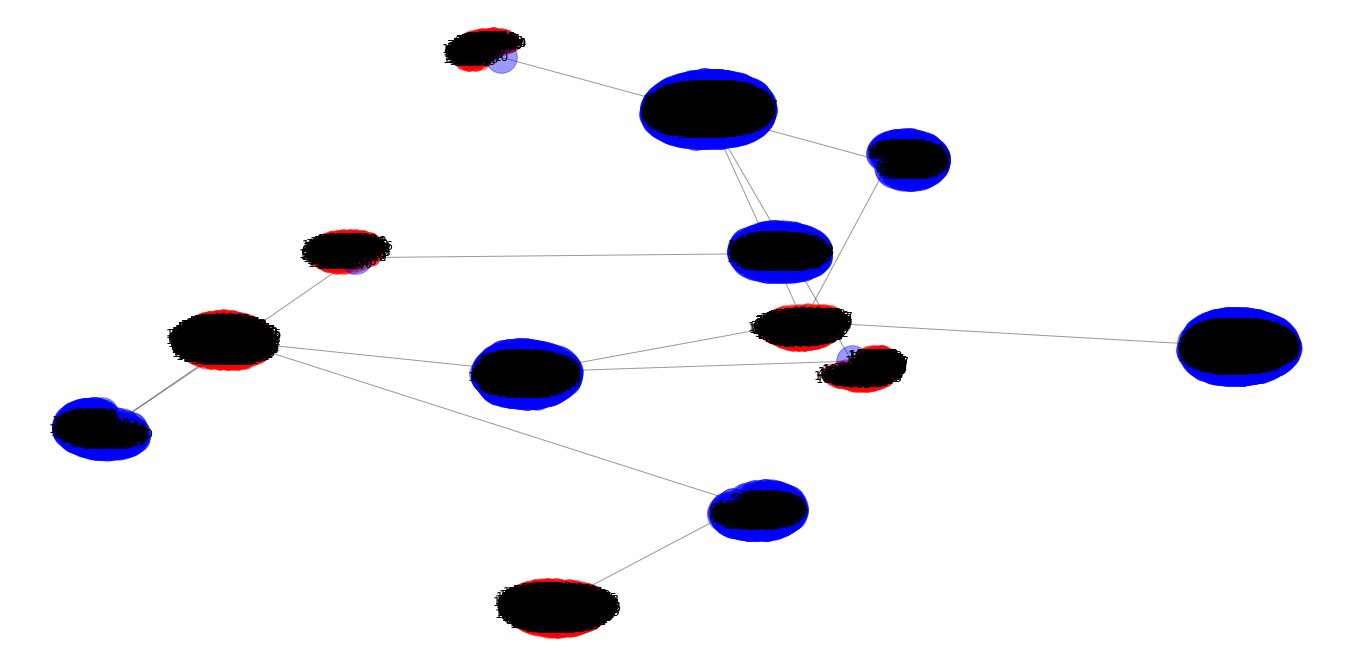

In [102]:
# Source node labels
graph = G
articles, topics = nx.bipartite.sets(graph)

# Plot graph by node type
# Apply plot settings
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (24,12)
plt.axis('off')
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, nodelist=articles, node_color='red', alpha = 0.4)
nx.draw_networkx_nodes(graph, pos, nodelist=topics, node_color='blue', alpha = 0.4, node_size = 1000)
nx.draw_networkx_edges(graph, pos, alpha = 0.4)
nx.draw_networkx_labels(graph, pos);

## Conclusion

## YouTube